## Luther Kaggle Data

I am working on this data concurrently with troubleshooting my webscraping code.  I will either use this data to enrich the data I pulled or as a substitute whilst still waiting for the code to finsh running.

The first section below will be involving only the main ted data.  I will be making the assumption that the view maturity of a video will be a year after its release.  I will store all data that has not been published for more than a year in its own df, and webscrape the current views to be used as an out-of-sample test set for my model. 

In [34]:
import pandas as pd
import numpy as np
import math
import re
import time
from datetime import *
from scipy import stats
import dateutil.parser
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400

In [35]:
#Reading in data
data = pd.read_csv('ted_main.csv')

In [36]:
#Exploring data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
comments              2550 non-null int64
description           2550 non-null object
duration              2550 non-null int64
event                 2550 non-null object
film_date             2550 non-null int64
languages             2550 non-null int64
main_speaker          2550 non-null object
name                  2550 non-null object
num_speaker           2550 non-null int64
published_date        2550 non-null int64
ratings               2550 non-null object
related_talks         2550 non-null object
speaker_occupation    2544 non-null object
tags                  2550 non-null object
title                 2550 non-null object
url                   2550 non-null object
views                 2550 non-null int64
dtypes: int64(7), object(10)
memory usage: 338.8+ KB


In [37]:
data.head()

comments                                        description  duration  \
0      4553  Sir Ken Robinson makes an entertaining and pro...      1164   
1       265  With the same humor and humanity he exuded in ...       977   
2       124  New York Times columnist David Pogue takes aim...      1286   
3       200  In an emotionally charged talk, MacArthur-winn...      1116   
4       593  You've never seen data presented like this. Wi...      1190   

     event   film_date  languages   main_speaker  \
0  TED2006  1140825600         60   Ken Robinson   
1  TED2006  1140825600         43        Al Gore   
2  TED2006  1140739200         26    David Pogue   
3  TED2006  1140912000         35  Majora Carter   
4  TED2006  1140566400         48   Hans Rosling   

                                            name  num_speaker  published_date  \
0      Ken Robinson: Do schools kill creativity?            1      1151367060   
1           Al Gore: Averting the climate crisis            1      1151367060   
2                  David Pogue: Simplicity sells            1      1151367060   
3             Majora Carter: Greening the ghetto            1      1151367060   
4  Hans Rosling: The best stats you've ever seen            1      1151440680   

                                             ratings  \
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   

                                       related_talks  \
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1  [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2  [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3  [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4  [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   

                     speaker_occupation  \
0                       Author/educator   
1                      Climate advocate   
2                  Technology columnist   
3    Activist for environmental justice   
4  Global health expert; data visionary   

                                                tags  \
0  ['children', 'creativity', 'culture', 'dance',...   
1  ['alternative energy', 'cars', 'climate change...   
2  ['computers', 'entertainment', 'interface desi...   
3  ['MacArthur grant', 'activism', 'business', 'c...   
4  ['Africa', 'Asia', 'Google', 'demo', 'economic...   

                             title  \
0      Do schools kill creativity?   
1      Averting the climate crisis   
2                 Simplicity sells   
3              Greening the ghetto   
4  The best stats you've ever seen   

                                                 url     views  
0  https://www.ted.com/talks/ken_robinson_says_sc...  47227110  
1  https://www.ted.com/talks/al_gore_on_averting_...   3200520  
2  https://www.ted.com/talks/david_pogue_says_sim...   1636292  
3  https://www.ted.com/talks/majora_carter_s_tale...   1697550  
4  https://www.ted.com/talks/hans_rosling_shows_t...  12005869

In [38]:

def CleanCols(df):
    df.drop('url', axis=1, inplace = True)
    df.drop('description', axis=1, inplace = True)
    df.drop('name', axis=1, inplace = True)
    df['published_date'] = data['published_date'].apply(lambda x: datetime.fromtimestamp(x).date())
    df['film_date'] = data['film_date'].apply(lambda x: datetime.fromtimestamp(x).date())
    df['days_online'] = data['published_date'].apply(lambda x: ((dateutil.parser.parse('9/22/2017').date()-x)))
    df['days_online'] = (data['days_online']/np.timedelta64(1, 'D')).astype(int)
    df['duration'] = round(data['duration']/60,2)
    #Using log views to get a better model
    df['log_views'] = data['views'].apply(lambda x: math.log(x))
    df['languages'] = data['languages'].replace(0,1)
    return df

In [39]:
#Removing unnecessary columns
CleanCols(data)


comments  duration           event   film_date  languages  \
0         4553     19.40         TED2006  2006-02-24         60   
1          265     16.28         TED2006  2006-02-24         43   
2          124     21.43         TED2006  2006-02-23         26   
3          200     18.60         TED2006  2006-02-25         35   
4          593     19.83         TED2006  2006-02-21         48   
5          672     21.75         TED2006  2006-02-01         36   
6          919     16.53         TED2006  2006-02-23         31   
7           46     19.97         TED2006  2006-02-22         19   
8          852     24.75         TED2006  2006-02-01         32   
9          900     21.03         TED2006  2006-02-24         31   
10          79     23.57         TED2006  2006-02-25         27   
11          55     25.63         TED2006  2006-02-25         20   
12          71     25.83         TED2006  2006-02-22         24   
13         242      8.78         TED2006  2006-02-05         27   
14          99     17.62         TED2006  2006-02-22         25   
15         325     24.68         TED2006  2006-02-22         31   
16         305     24.08         TED2004  2004-02-25         32   
17          88     15.10         TED2006  2006-02-23         27   
18         163     19.50         TED2005  2005-02-24         22   
19          84     20.02  TEDGlobal 2005  2005-07-13         32   
20         108     18.57         TED2006  2006-02-22         27   
21         185     18.93         TED2004  2004-02-23         26   
22          50     16.77         TED2006  2006-02-22         20   
23         556     23.45         TED2006  2006-02-23         33   
24         117     20.42         TED2004  2004-02-03         23   
25         184     19.00  TEDGlobal 2005  2005-07-13         29   
26         507     21.93  TEDGlobal 2005  2005-07-06         36   
27          95     21.25         TED2004  2004-02-26         25   
28         355     17.50         TED2004  2004-02-25         37   
29         970     21.27         TED2004  2004-02-01         43   
...        ...       ...             ...         ...        ...   
2520        81     12.27         TED2017  2017-04-23          2   
2521        13     11.42    TEDxStanford  2016-04-23          7   
2522        12      8.83         TED2017  2017-04-23          5   
2523        20     12.45    TEDxCrenshaw  2016-10-07          3   
2524         9      5.17         TED2017  2017-04-23         12   
2525        18     13.18      TEDxSydney  2016-05-23          5   
2526        39     13.62         TED2017  2017-04-23          6   
2527        17     14.42    TEDxStanford  2017-04-22          3   
2528         3     11.95     TEDxHamburg  2016-06-07          5   
2529        45     19.27      TEDxExeter  2015-04-23          1   
2530        12     12.30         TED2017  2017-04-23          3   
2531        18     11.63       TEDxGhent  2016-06-17          1   
2532        25     16.55         TED2017  2017-04-23          2   
2533         9     11.05         TED2017  2017-04-23          2   
2534         2     12.08       TEDxSkoll  2017-04-06          1   
2535         8     12.05  TEDGlobal 2017  2017-08-26          4   
2536        21     14.42    TEDxMileHigh  2017-07-07          5   
2537        39     12.30         TED2017  2017-04-23          2   
2538         7     13.47      TEDxZurich  2016-11-10          1   
2539        10     15.57         TED2017  2017-08-26          2   
2540        33     12.03         TED@UPS  2017-07-19          4   
2541        12     15.95  TEDxManchester  2017-02-18          2   
2542         3     13.25  TEDGlobal 2017  2017-08-26          1   
2543         7     14.90         TED2017  2017-04-23          1   
2544        10     13.50  TEDGlobal 2017  2017-08-26          1   
2545        17      7.93         TED2017  2017-06-05          4   
2546         6      4.83         TED2017  2017-04-23          3   
2547        10     10.85         TED2017  2017-04-23 

In [40]:
#Setting aside videos that had been online for less than a year to use as an out of sample test set for the model
test_df = data[data['days_online'] < 364]
test_df

comments  duration                  event   film_date  languages  \
2288        66     14.70                 TEDNYC  2016-09-06         21   
2289        23      4.60             TED Studio  2016-05-31         33   
2290        20     13.35          TED@BCG Paris  2016-05-17         21   
2291       490     14.45              TEDSummit  2016-06-25         27   
2292        36     19.08              TEDSummit  2016-06-26         25   
2293        39      9.88              TEDSummit  2016-06-26         28   
2294        72     12.70                 TEDNYC  2016-09-06         22   
2295        56     12.70           TEDxStanford  2016-04-23         23   
2296       109     11.77              TEDSummit  2016-06-25         33   
2297        13      4.48             TED Studio  2016-05-01         33   
2298        83     10.02                TED2016  2016-02-15         34   
2299        29     14.15              TEDSummit  2016-06-29         24   
2300        32     10.08              TEDSummit  2016-06-29         28   
2301        25      9.80            TEDMED 2015  2015-11-17         26   
2302        24     13.35          TED@BCG Paris  2016-05-17         23   
2303        86     15.55           TEDxMontreal  2015-11-06         16   
2304        39     17.13              TEDSummit  2016-06-28         20   
2305        24      9.65            TEDMED 2015  2015-11-17         29   
2306        84     17.70              TEDSummit  2016-06-28         23   
2307        45     17.37             TEDxExeter  2016-04-14         25   
2308        38     10.85                 TEDNYC  2016-09-06         20   
2309        93     11.52                TED@UPS  2016-09-14         29   
2310        49     15.62            TEDxNewYork  2016-09-09         23   
2311        31     13.13  TEDxIndianaUniversity  2015-11-12         24   
2312        18     16.55             TEDxAthens  2016-02-05         27   
2313         6      8.72                TED2016  2016-02-15         25   
2314       326     12.33             TEDxSydney  2016-05-23         26   
2315       146      7.73              TEDSummit  2016-06-28         30   
2316       128     13.83       TEDxBeaconStreet  2015-11-13         19   
2317        11     11.25                TED@UPS  2016-09-14         21   
...        ...       ...                    ...         ...        ...   
2520        81     12.27                TED2017  2017-04-23          2   
2521        13     11.42           TEDxStanford  2016-04-23          7   
2522        12      8.83                TED2017  2017-04-23          5   
2523        20     12.45           TEDxCrenshaw  2016-10-07          3   
2524         9      5.17                TED2017  2017-04-23         12   
2525        18     13.18             TEDxSydney  2016-05-23          5   
2526        39     13.62                TED2017  2017-04-23          6   
2527        17     14.42           TEDxStanford  2017-04-22          3   
2528         3     11.95            TEDxHamburg  2016-06-07          5   
2529        45     19.27             TEDxExeter  2015-04-23          1   
2530        12     12.30                TED2017  2017-04-23          3   
2531        18     11.63              TEDxGhent  2016-06-17          1   
2532        25     16.55                TED2017  2017-04-23          2   
2533         9     11.05                TED2017  2017-04-23          2   
2534         2     12.08              TEDxSkoll  2017-04-06          1   
2535         8     12.05         TEDGlobal 2017  2017-08-26          4   
2536        21     14.42           TEDxMileHigh  2017-07-07          5   
2537        39     12.30                TED2017  2017-04-23          2   
2538         7     13.47             TEDxZurich  2016-11-10          1   
2539        10     15.57                TED2017  2017-08-26          2   
2540        33     12.03                TED@UPS  2017-07-19          4   
2541        12     15.95         TEDxManchester  2017-02-18          2   
2542      

In [41]:
# Filtering out the test set
data = data[data['days_online'] >= 365]

## Preliminary Plots 

Making some preliminary plots to get a better idea of what the data shows and to help decide what factors will be incorporated in the linear regression.  I will need to find a way to normalize the time component so we are comparing apples to apples. 

As seen below, log_views has the greatest correlation with the number of languages the transcript is available in and the amount of comments.  The former makes sense because the broader the audience, the more views it will get.  The latter (comments) is most likely true for 2 reasons. First, if someone leaves a comment, they will return to the page later to see other comments or respond to comments on their comment.  Either case counts as another 'view'.  Secondly, the comments can be an indicator about how people enjoyed the video and if a video is enjoyable.

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


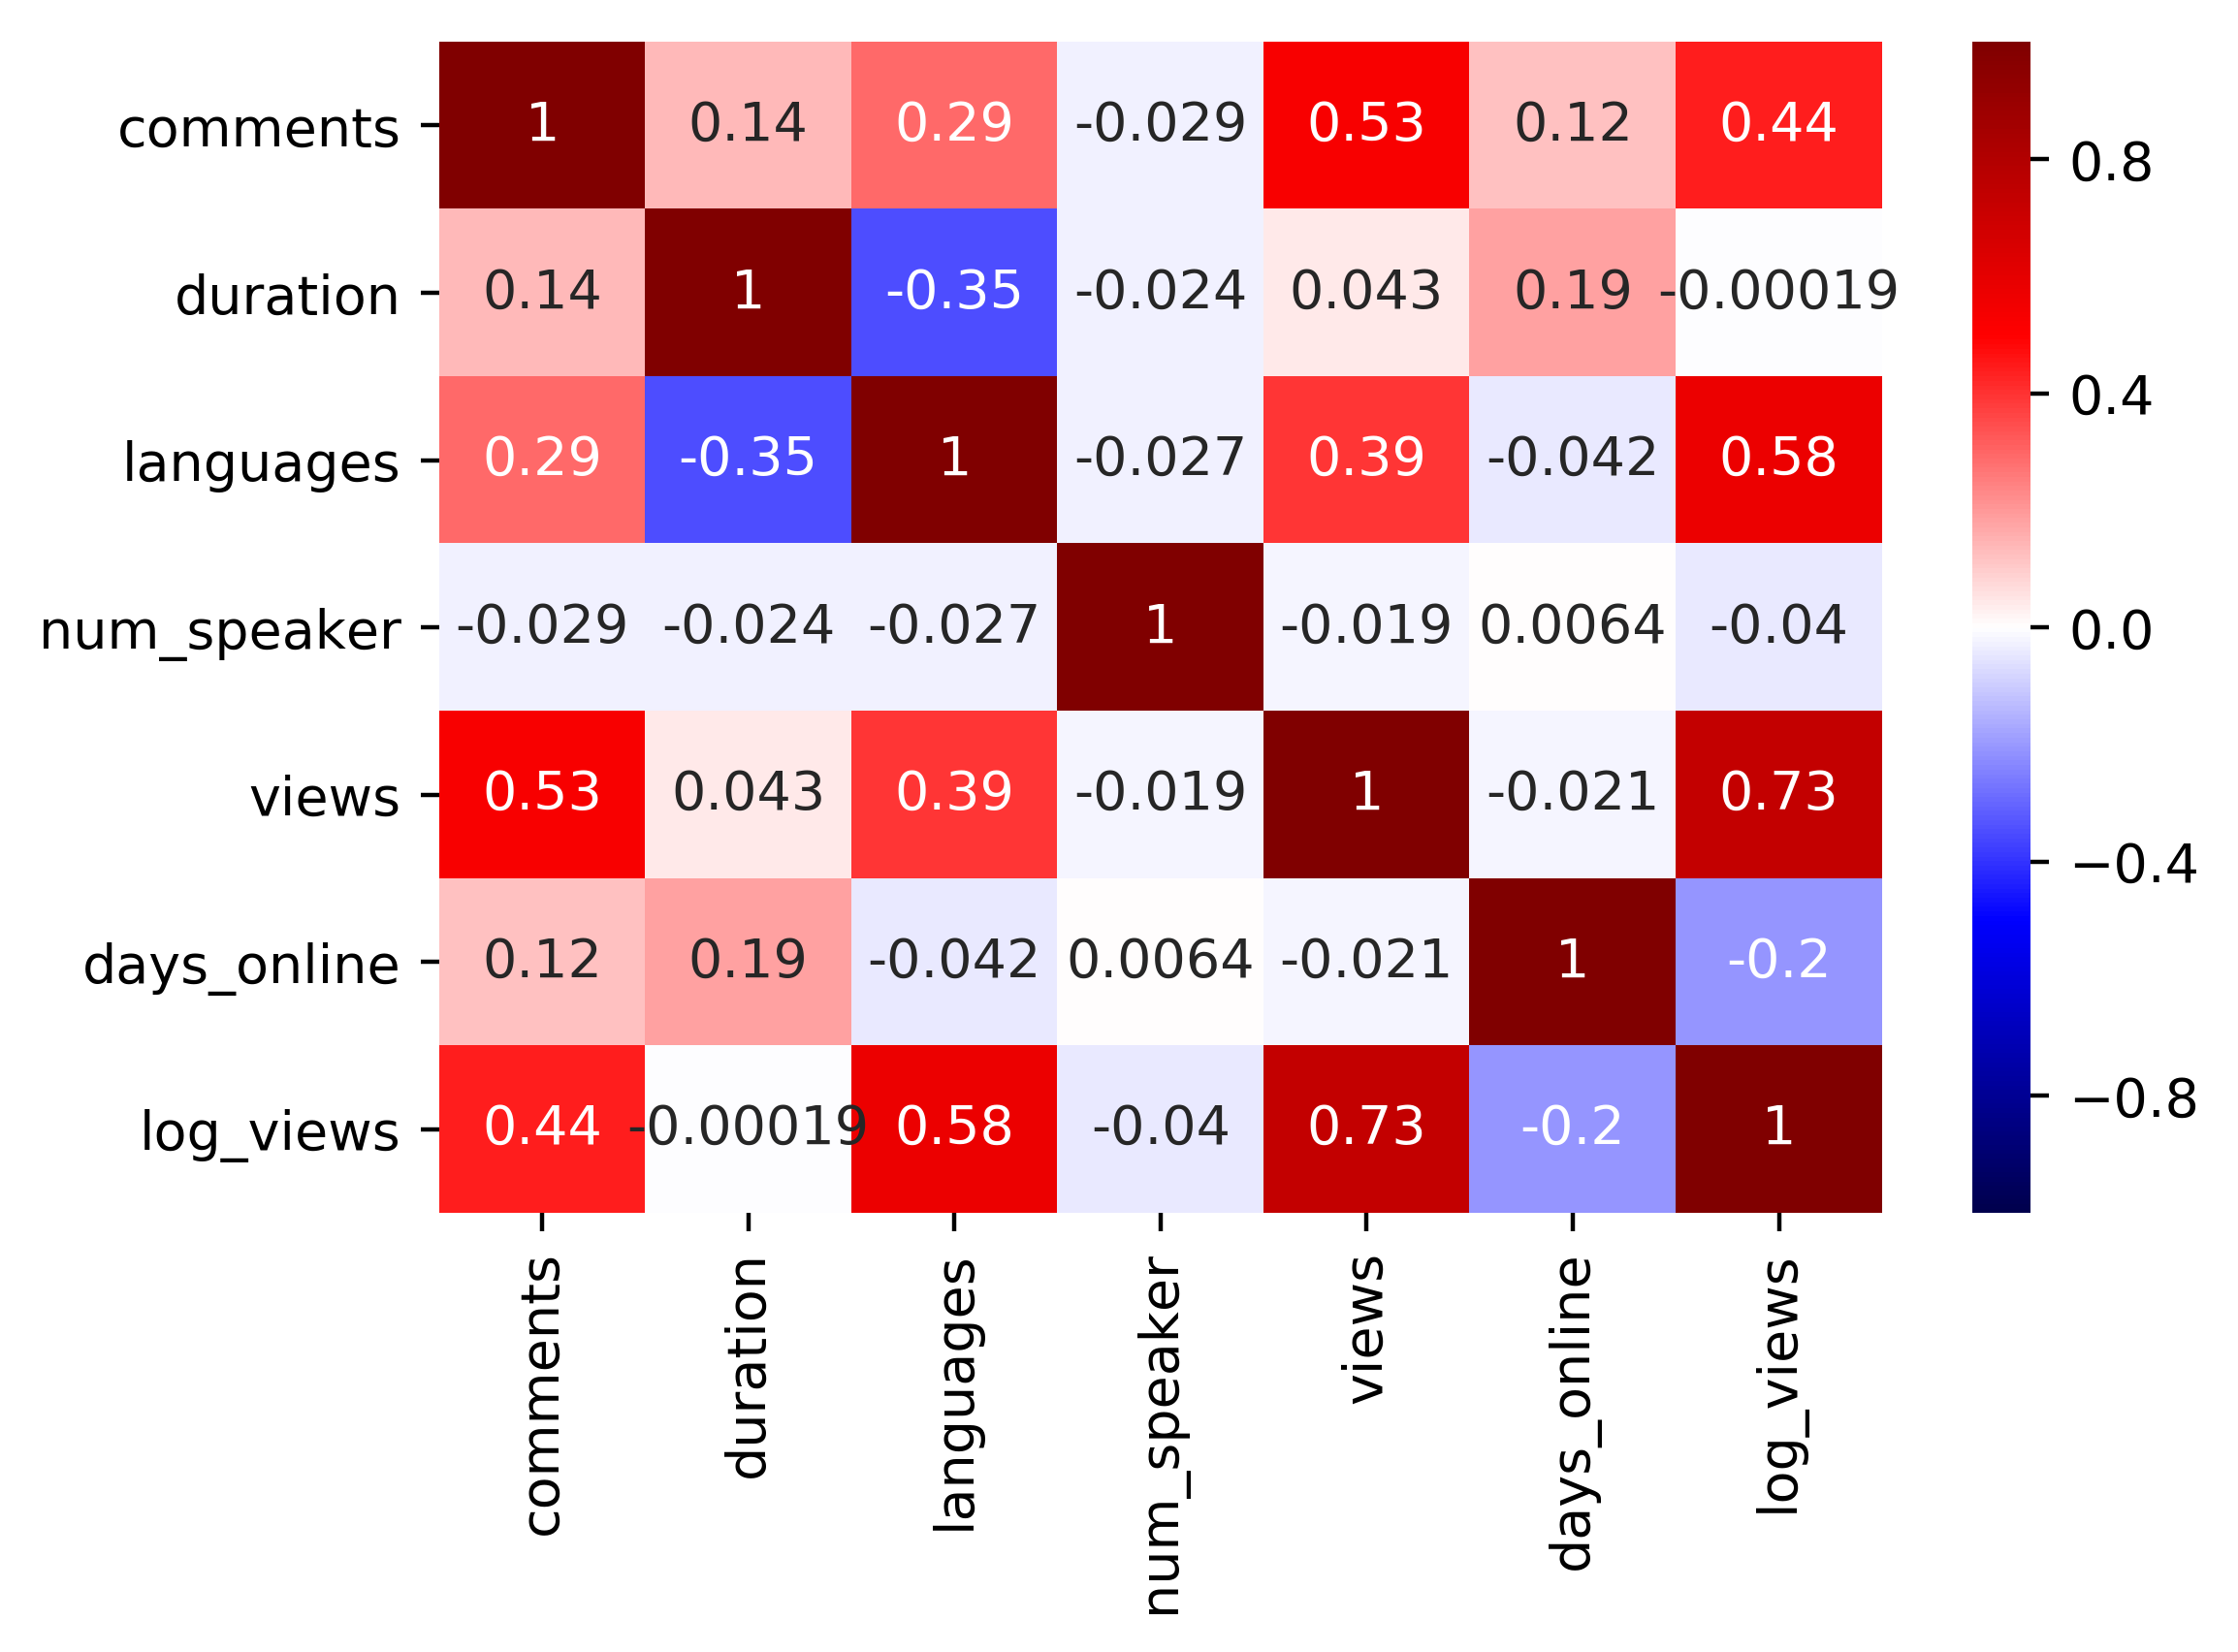

In [43]:
# Checking the data for correlations between variables
plt.savefig("test.png", format="png")
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap=('seismic'), annot = True)

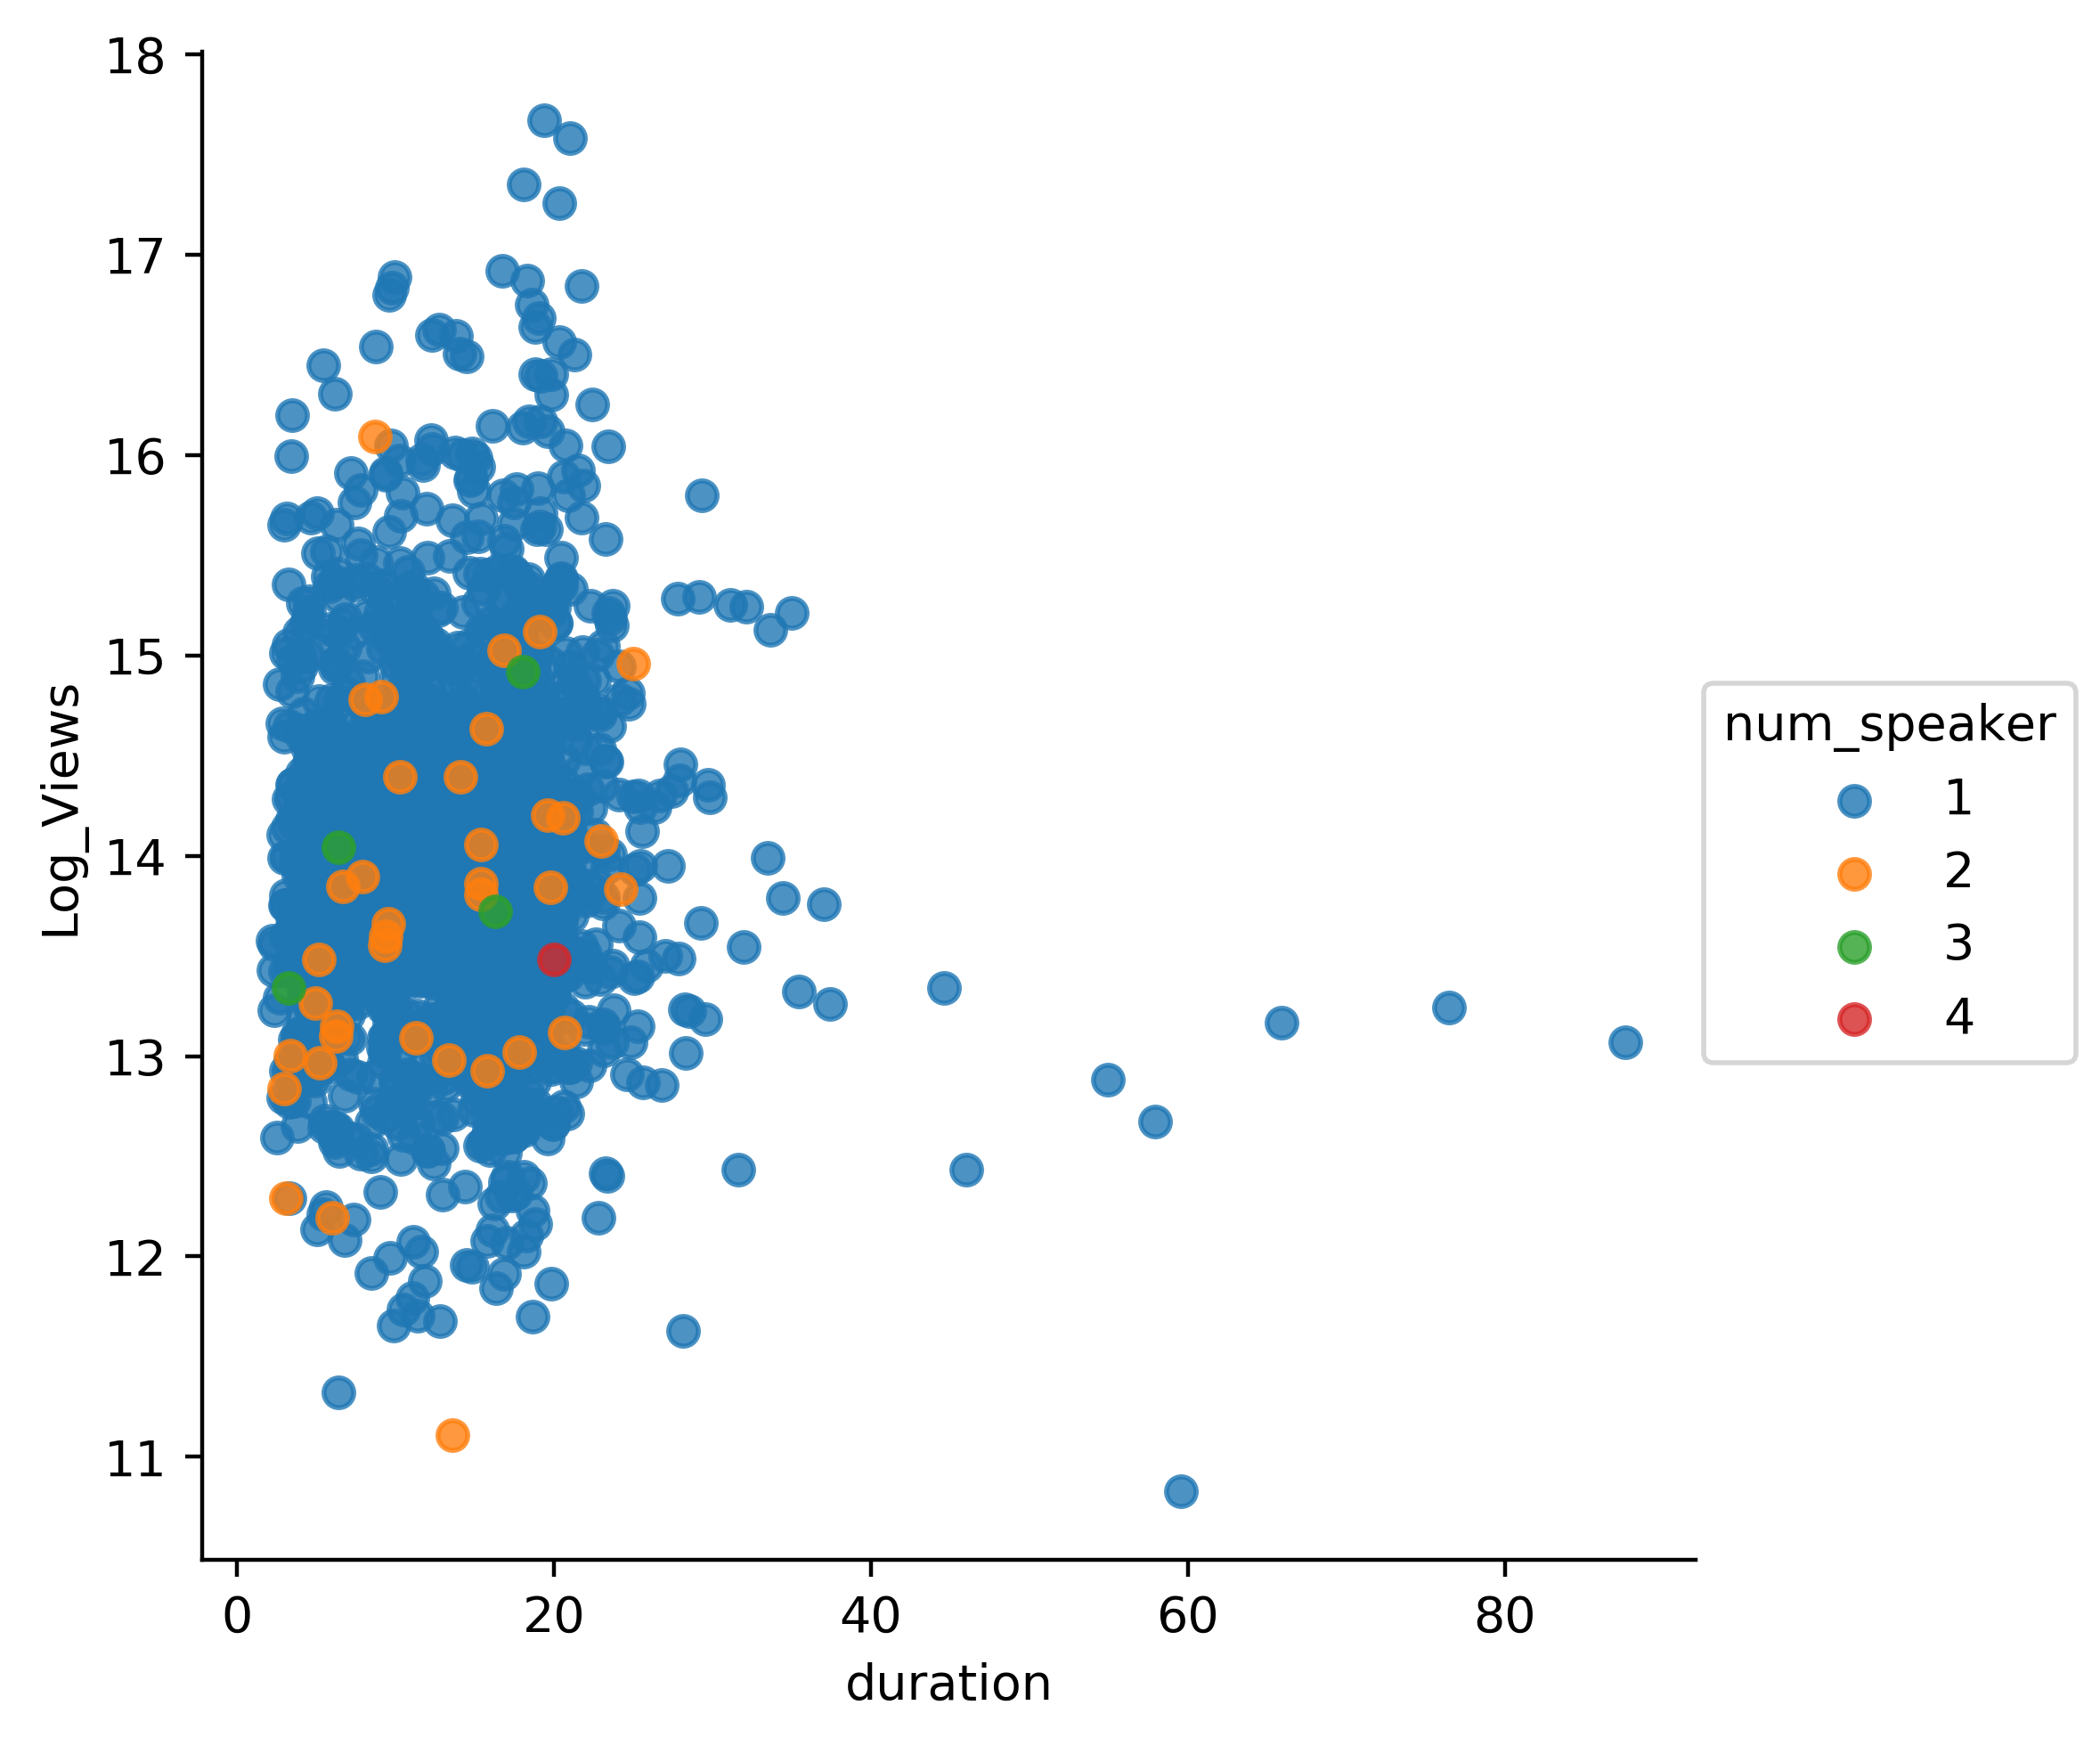

In [44]:
#There really is no correlation between duration and number of speakers, or view count
fig = sns.lmplot(y="log_views", x="duration", data=data, hue = 'num_speaker', fit_reg = False)
fig = fig.set_axis_labels('duration', 'Log_Views')

In [45]:
#Extracting the indeces for the highest view count for reference
four_highest = data[data.views>21000000].ratings.index
four_highest

Int64Index([0, 201, 452, 677, 837, 1346, 1776], dtype='int64')

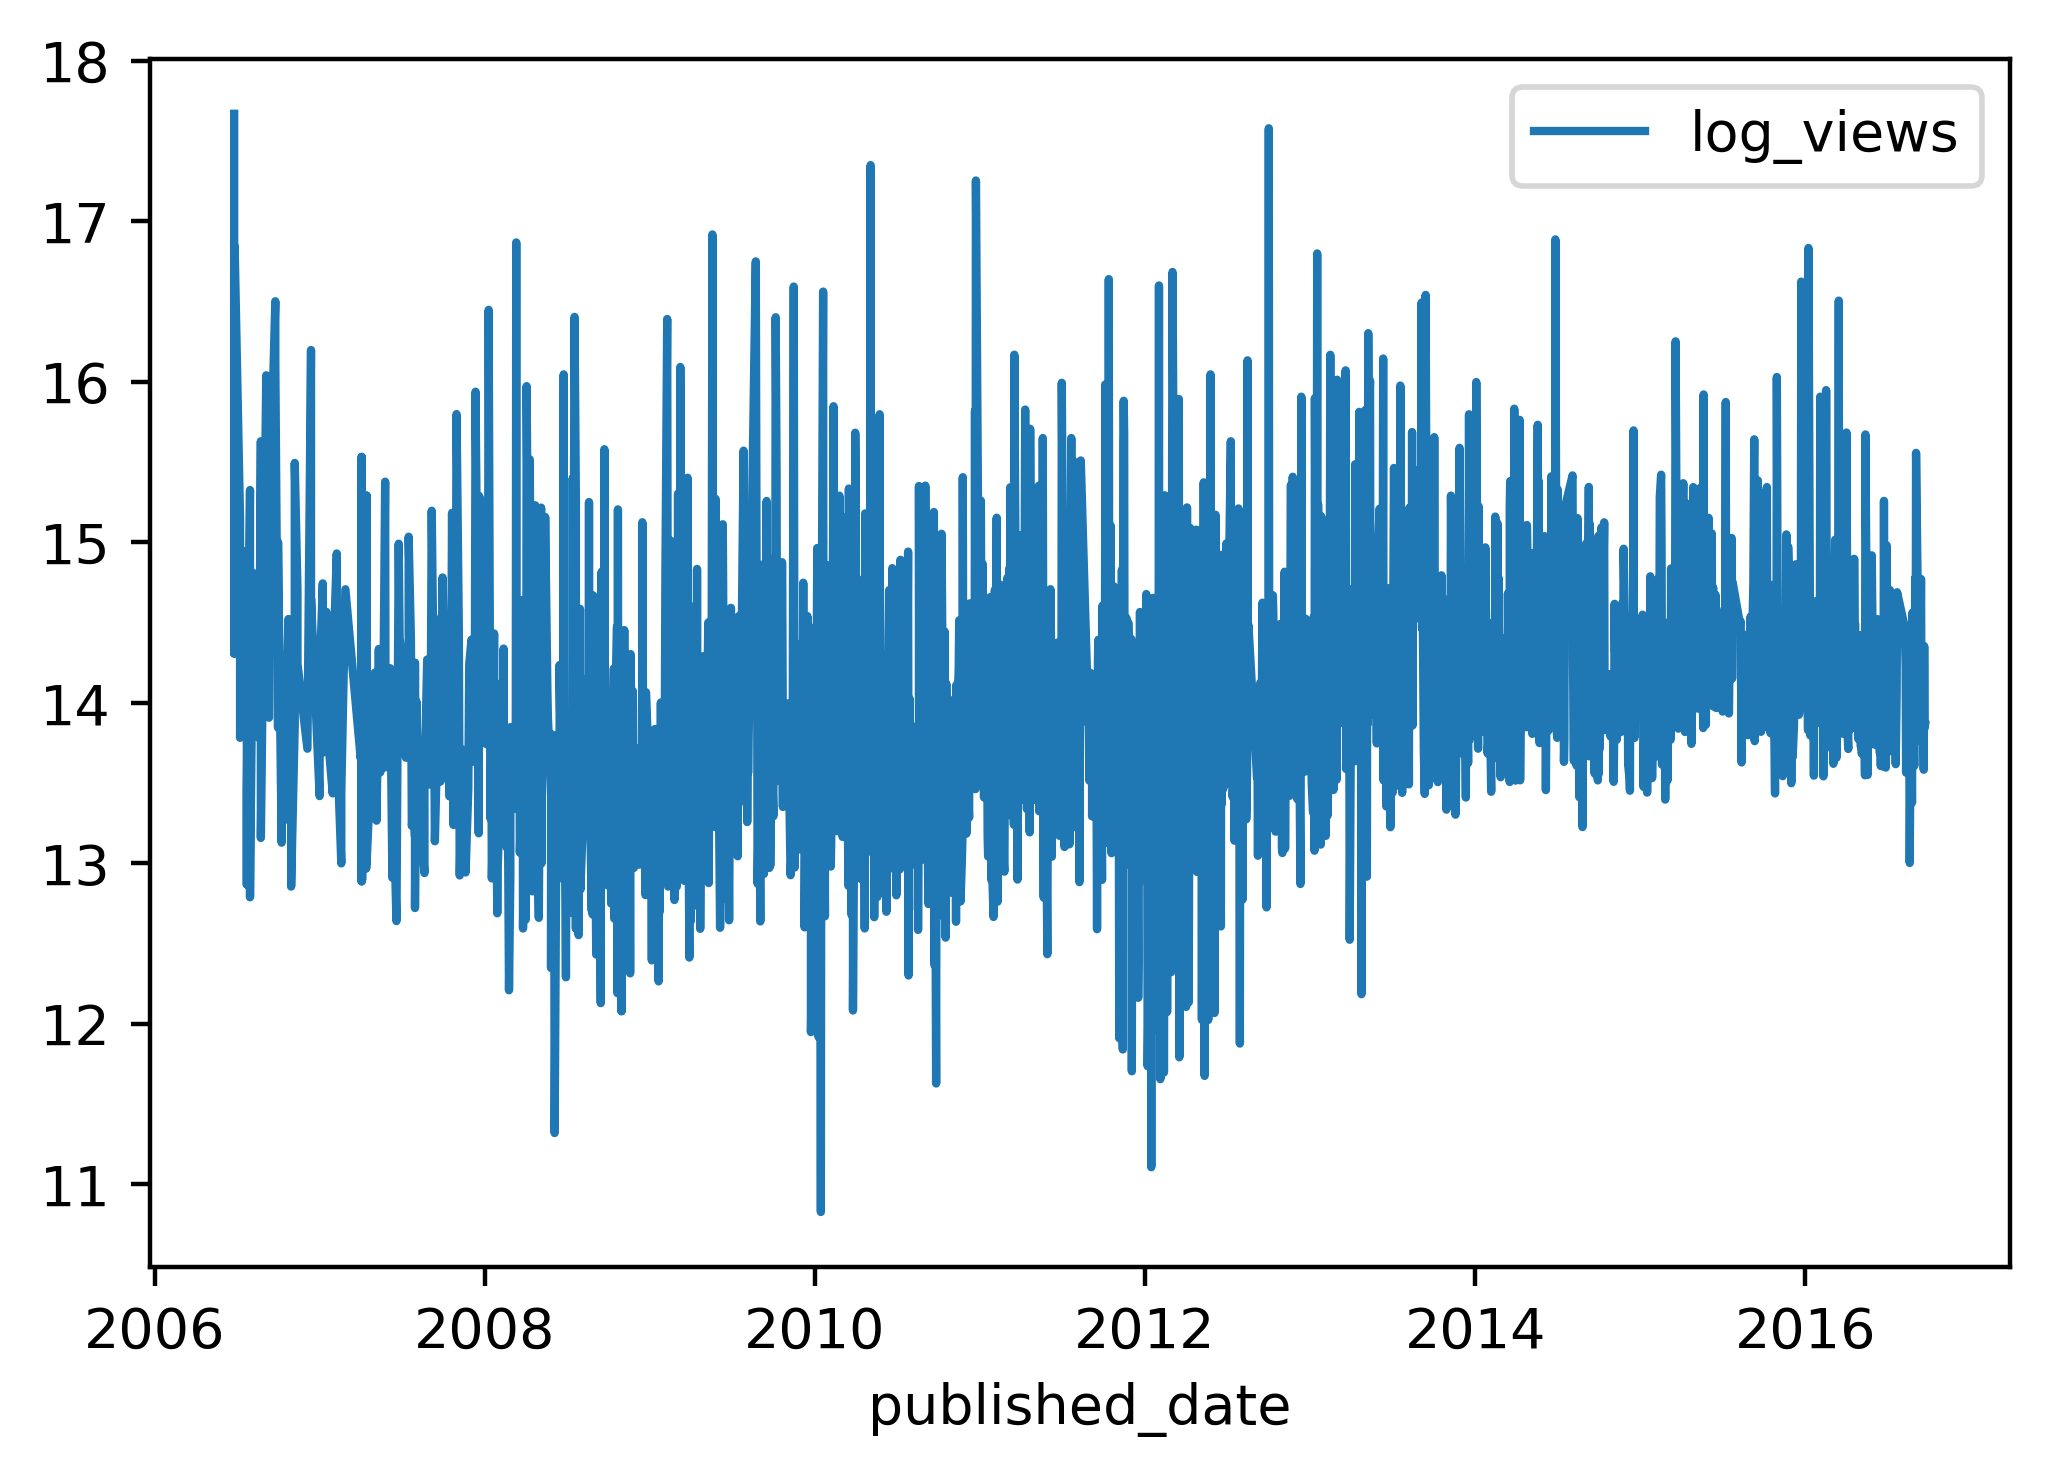

In [46]:
data[['published_date','log_views']].set_index('published_date').plot()

In [47]:
#data[['comments','views']].set_index('published_date').plot()

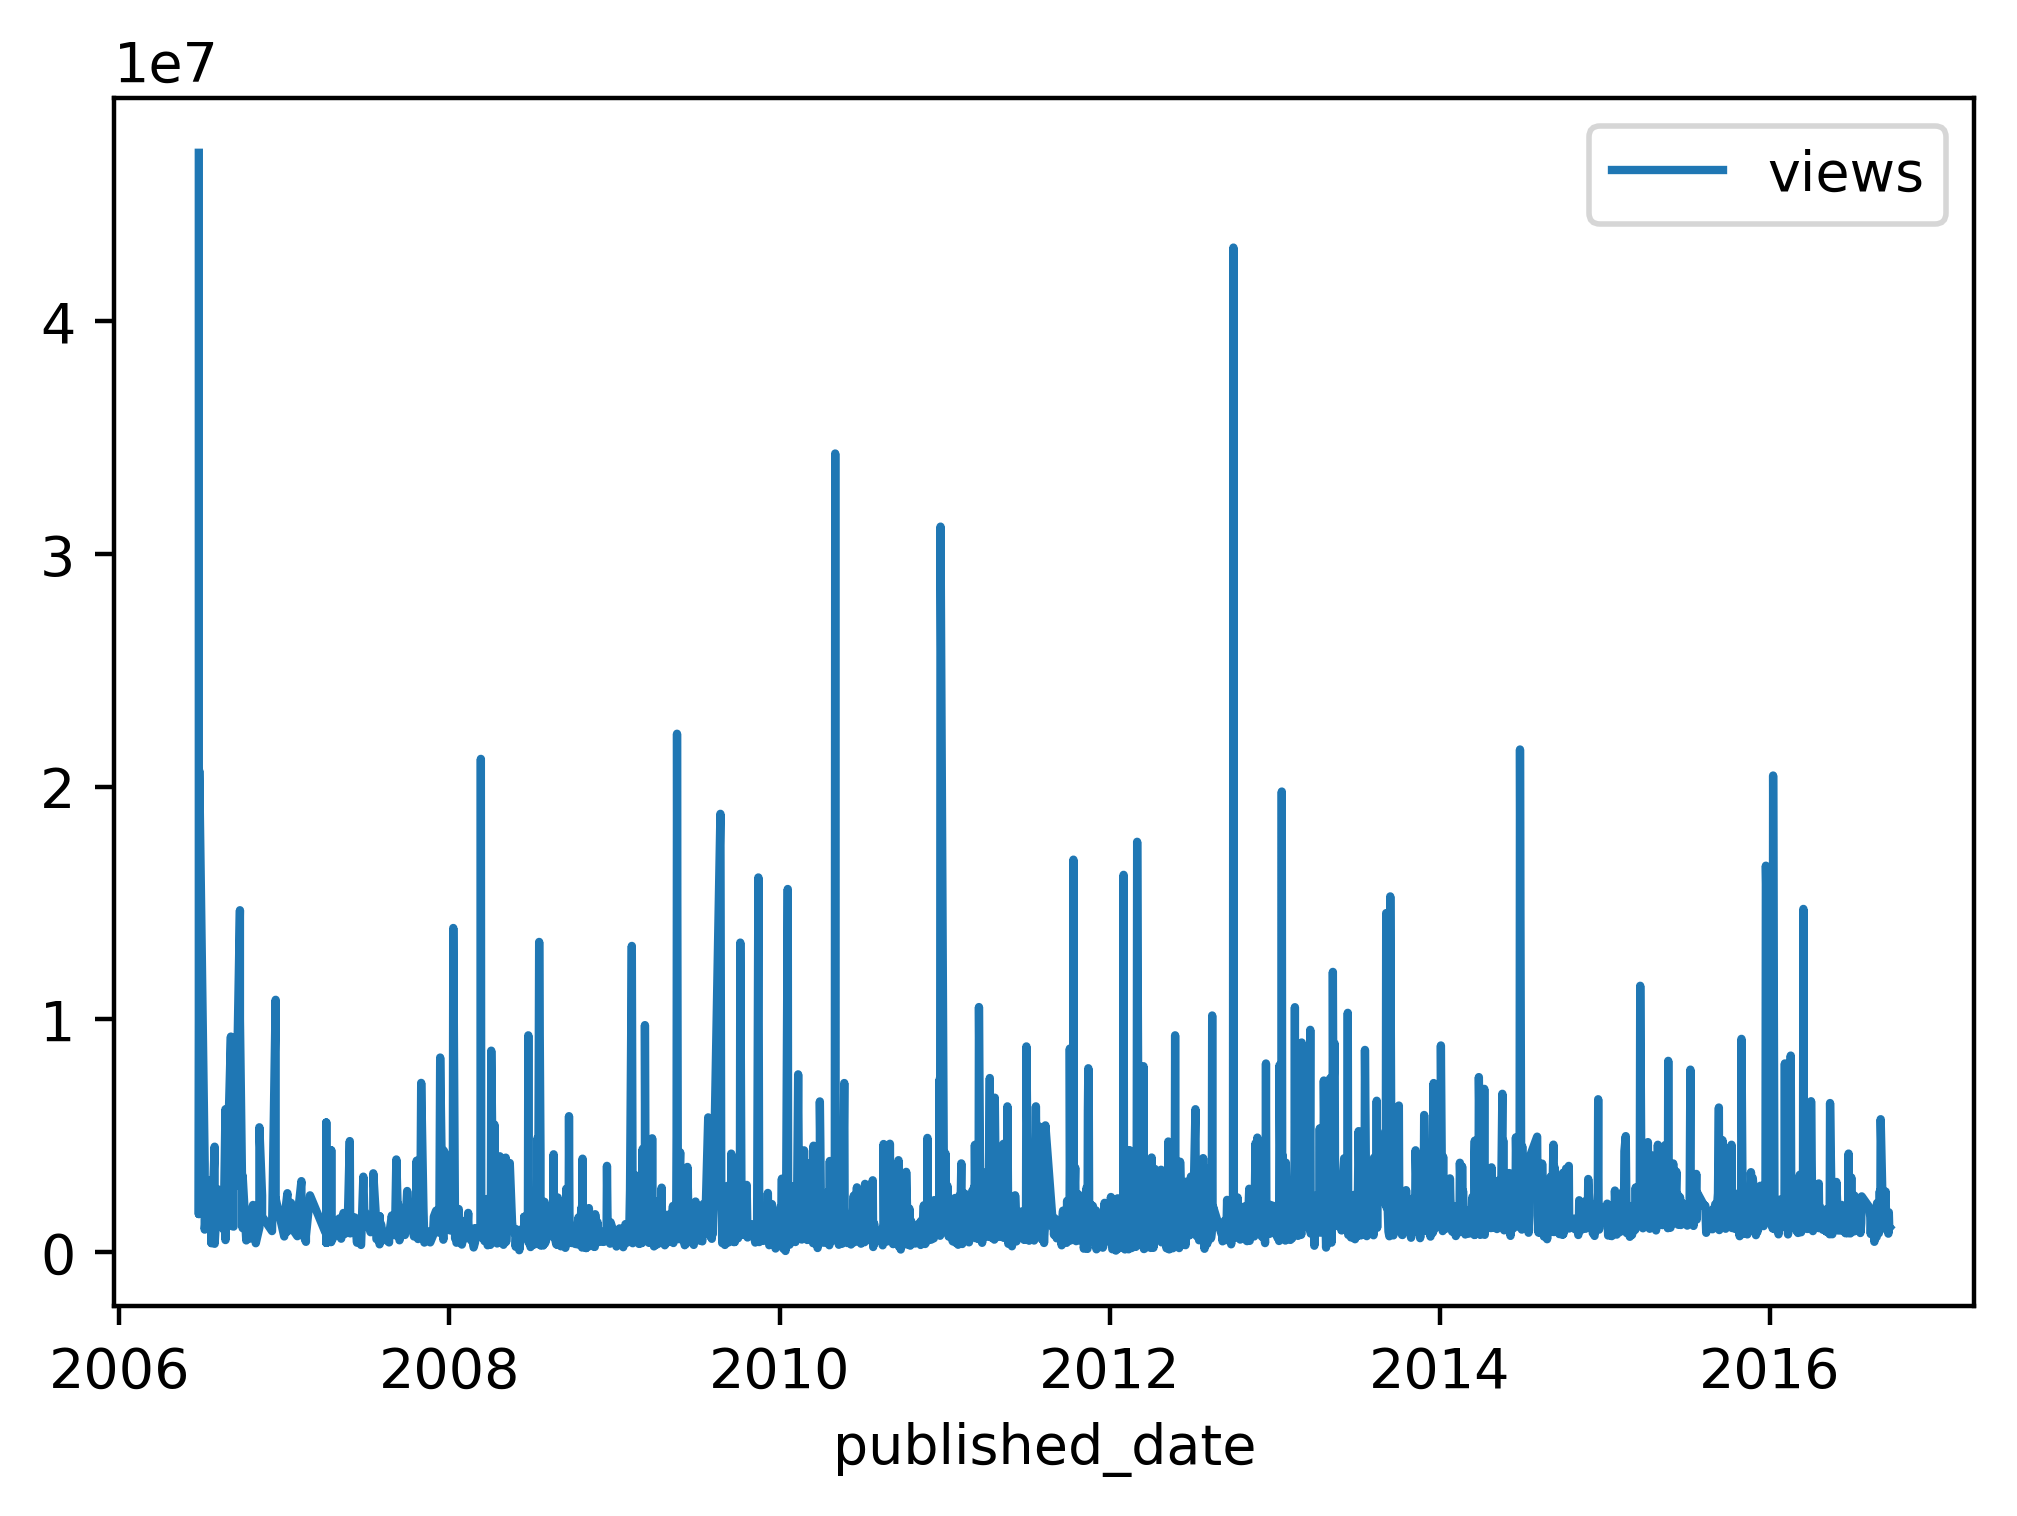

In [48]:
data[['published_date','views']].set_index('published_date').plot()

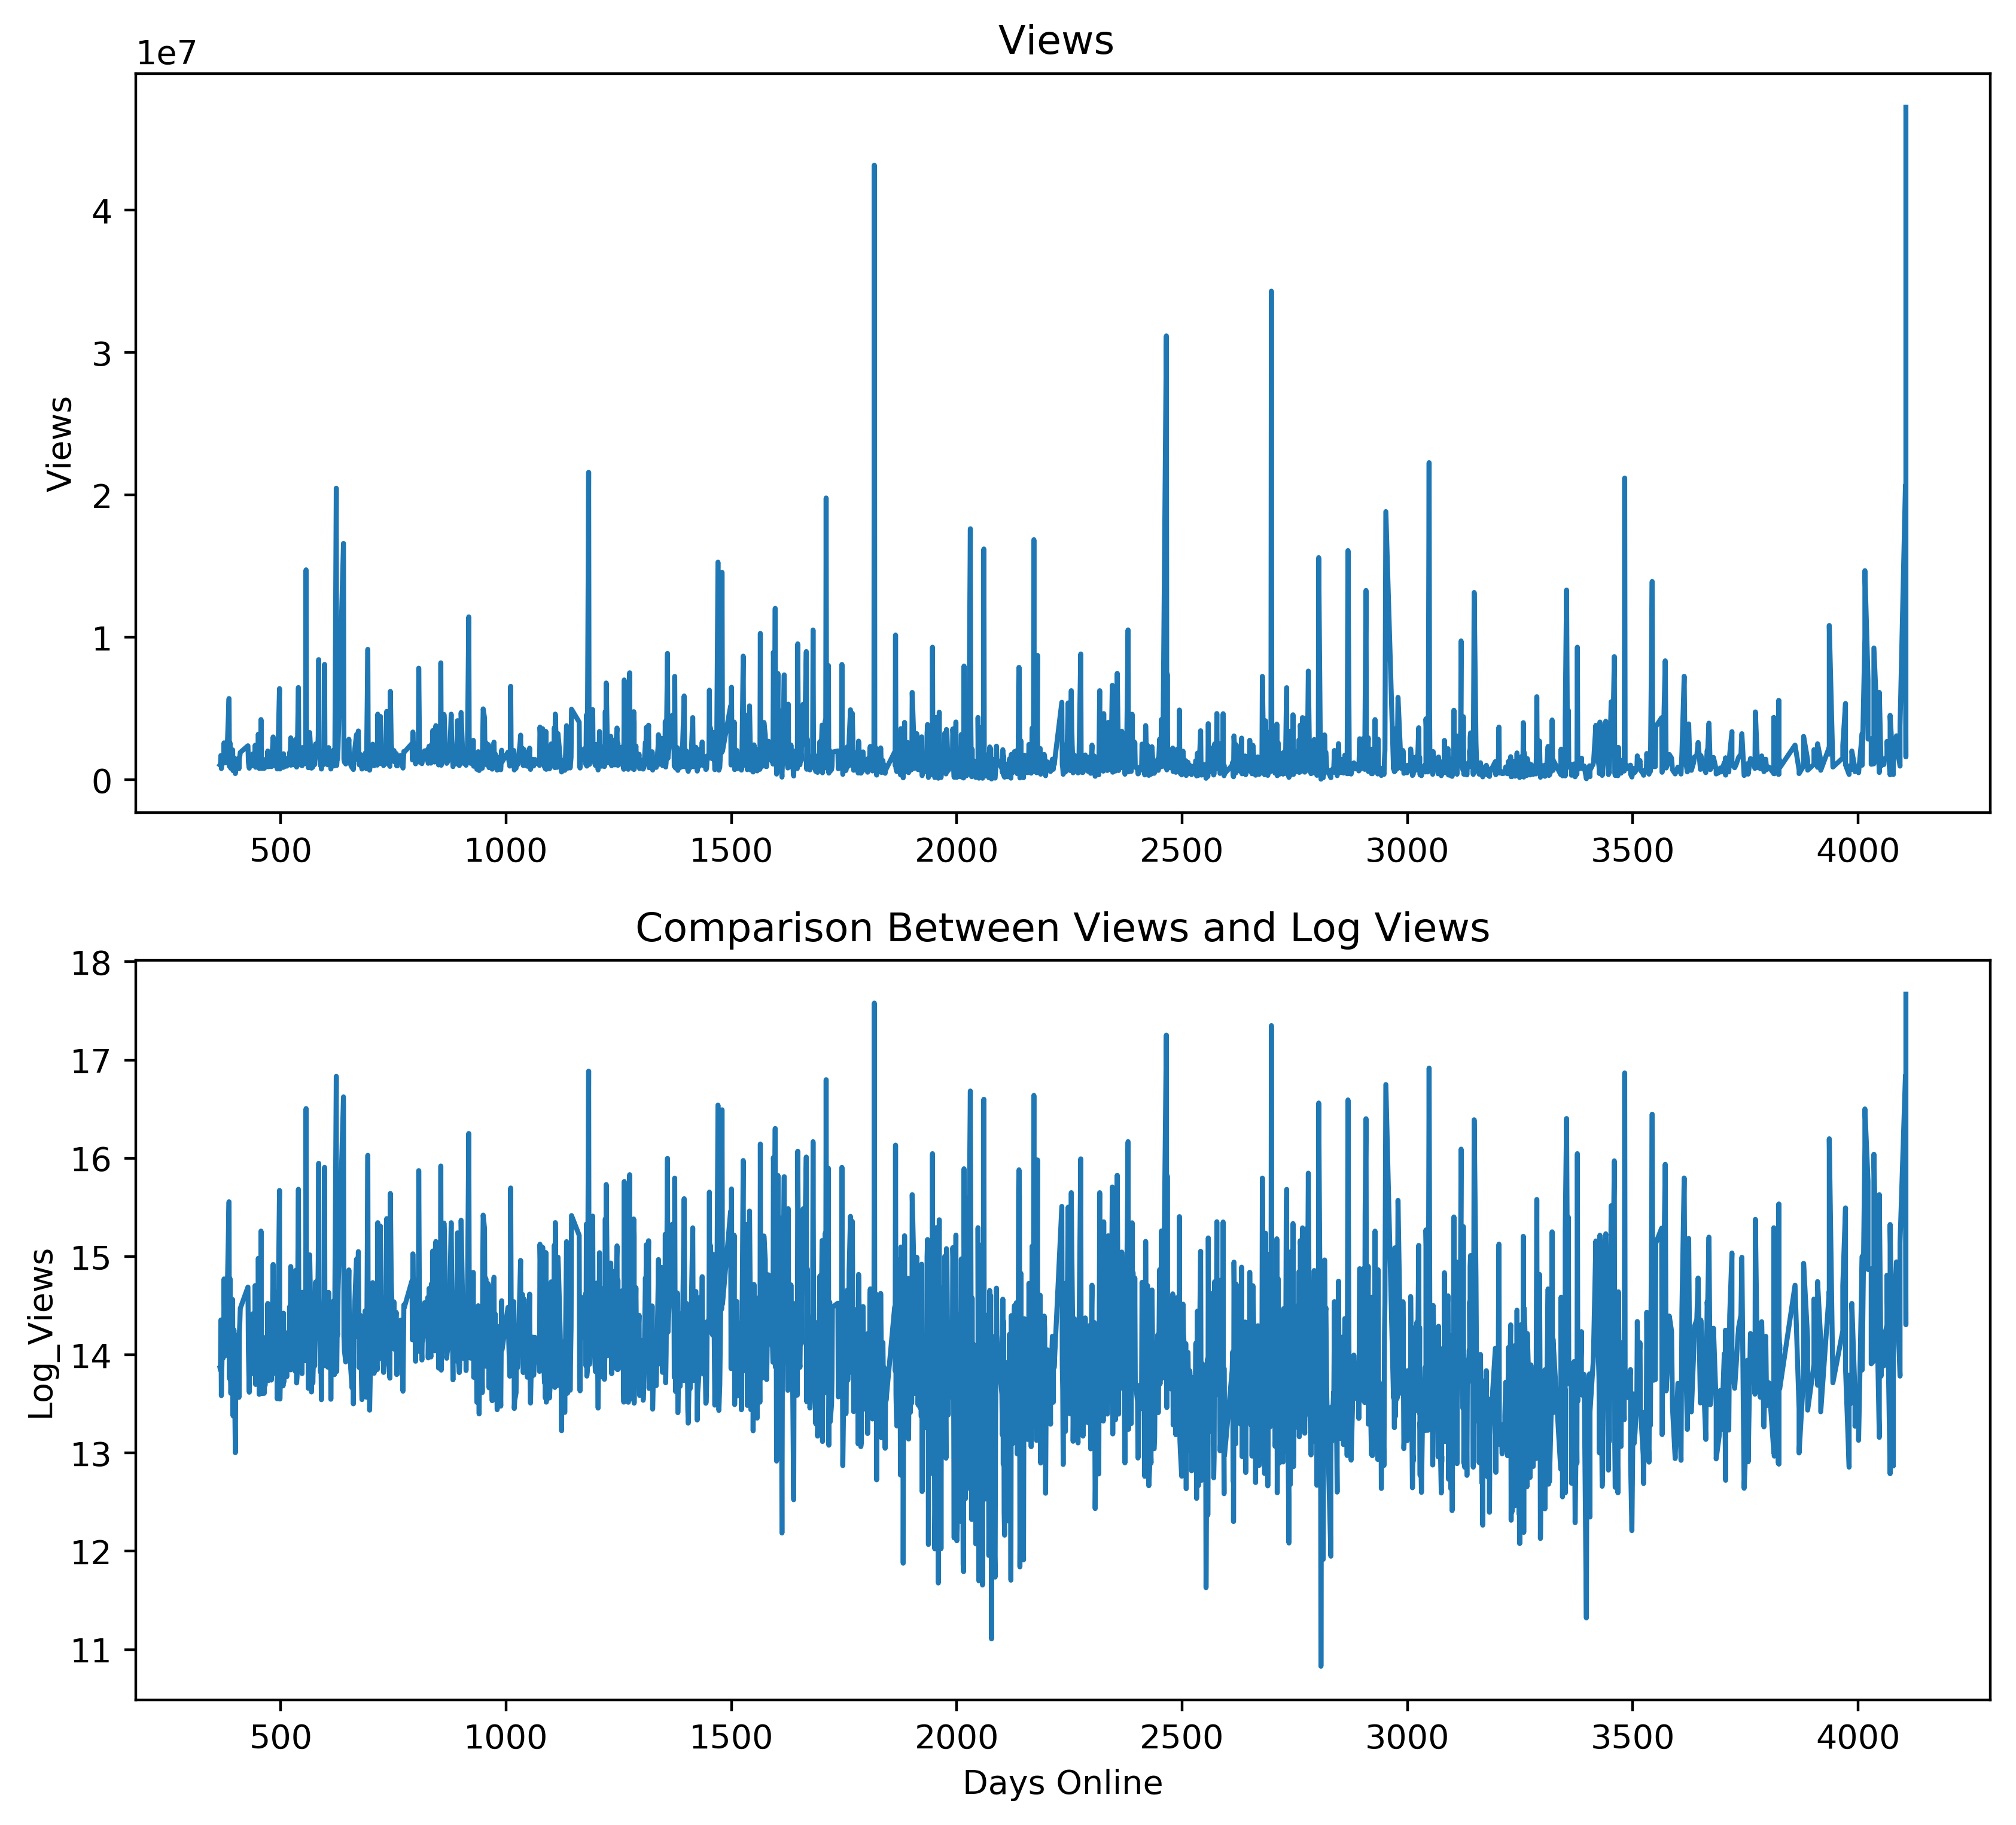

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9))  # 2 Rows, 1 Col

ax[0].plot(data['days_online'],data['views'])
ax[0].set_title('Views ')
ax[0].set_ylabel('Views')

ax[1].plot(data['days_online'], data['log_views'])
ax[1].set_xlabel('Days Online')
ax[1].set_ylabel('Log_Views')
ax[1].set_title('Comparison Between Views and Log Views');


## Pulling out reactions

Each video has its own ratings, or reactions the watchers have during or after the video.  The number of reactions were changed to proportions to normalize for each video, so we can compare the distribution of reactions based on number of views and other factors. 

In [50]:
#Pulls the number of tags for a certain tag
def FindTag(tag, sl):
    hand = False
    count = 0
    for i in sl:
        if tag in i:
            hand = True
        elif hand == True:
            count = int(i.split('}')[0].strip())
            hand= False
    return count

In [51]:
# calling in each tag individually to run through the broken comment.  I am doing this so its easier to 
# join the dataframes later (and match the number to the correct column)
def CrackShell(string):
    tag_list=['Courageous', 'Beautiful', 'Confusing', 'Funny', 'Ingenious', 'Unconvincing', \
          'Longwinded', 'Informative', 'Inspiring', 'Fascinating', 'Persuasive', 'Jaw-dropping','Obnoxious']
    comment = string.split(':')
    emotes = []

    for i in tag_list:
        emotes.append(FindTag(i, comment))
    return emotes

In [52]:
#creates the reaction dictionary (emote_dict), and passes all possible reactions to the functions defined above
emote_dict = {}
tag_list=['Courageous', 'Beautiful', 'Confusing', 'Funny', 'Ingenious', 'Unconvincing', \
          'Longwinded', 'Informative', 'Inspiring', 'Fascinating', 'Persuasive', 'Jaw-dropping','Obnoxious']
for i in range(len(data.ratings)):
        emote_dict[i] = CrackShell(data.ratings[i])

In [53]:
#Turning dictionary into Dataframe
from pandas import DataFrame
emote_df = pd.DataFrame.from_dict(emote_dict, orient = 'index')

In [54]:
#adding column names to DF, then changing reaction count to reaction proportion, the last line is checking
# that the proportions do not exceed 1
emote_df.columns = tag_list
for i in range(0,len(emote_df.index)):
    emote_df.loc[i,:] = emote_df.loc[i,:] / emote_df.loc[i,:].sum()
emote_df.iloc[2286,:].sum()

0.9999999999999999

In [55]:
#combining reaction DF with the original DF (data), then dropping the ratings column as it is no longer needed.
df= data.join(emote_df)
df= df.drop('ratings', axis=1)

In [209]:
drop_tag_list=['Courageous', 'Beautiful','Ingenious','Informative','Persuasive']

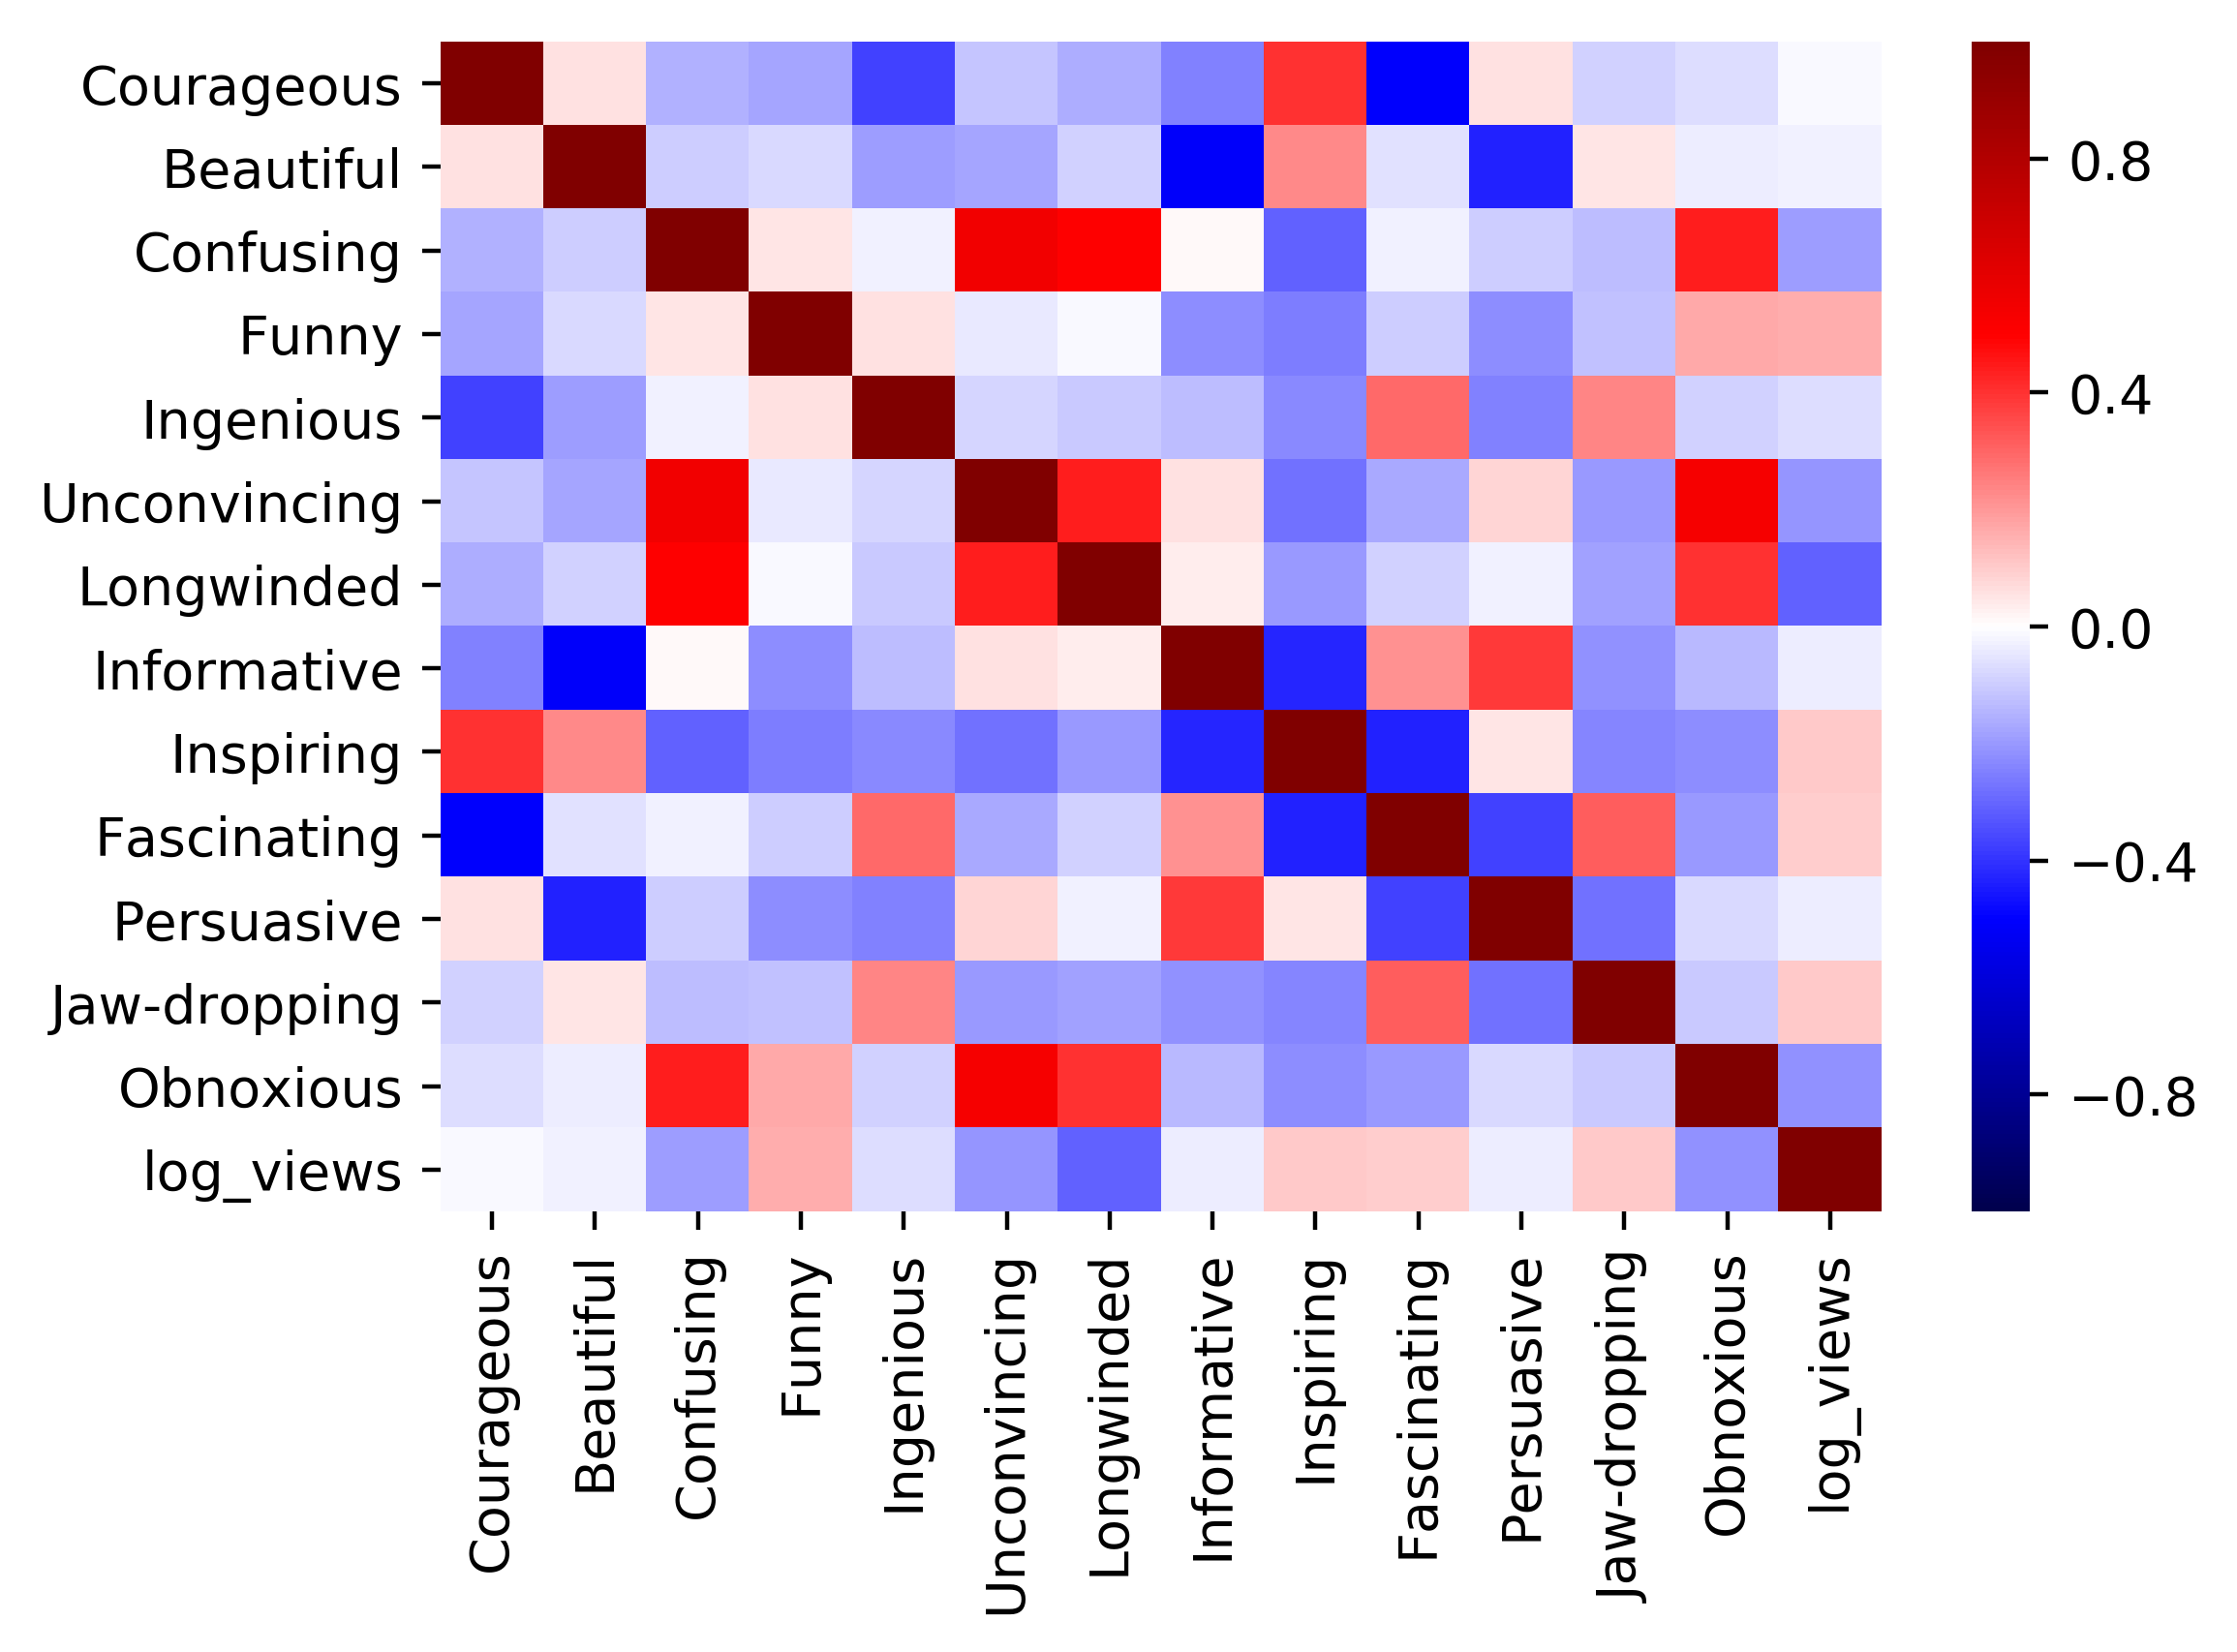

In [210]:
emote_heat = emote_df.copy()
emote_heat['log_views'] = data['log_views']
sns.heatmap(emote_heat.corr(), cmap='seismic', vmin = -1, vmax=1)

In [ ]:
(, , , , , , , , , , , ),'Inspiring'

In [ ]:
sns.lmplot(x = 'Ingenious', y='log_views', data=emote_heat)
sns.lmplot(x = 'Courageous', y='log_views', data=emote_heat)
sns.lmplot(x = 'Beautiful', y='log_views', data=emote_heat)
sns.lmplot(x = 'Confusing', y='log_views', data=emote_heat)
sns.lmplot(x = 'Funny', y='log_views', data=emote_heat)
sns.lmplot(x = 'Unconvincing', y='log_views', data=emote_heat)
sns.lmplot(x = 'Longwinded', y='log_views', data=emote_heat)
sns.lmplot(x = 'Informative', y='log_views', data=emote_heat)
sns.lmplot(x = 'Inspiring', y='log_views', data=emote_heat)
sns.lmplot(x = 'Fascinating', y='log_views', data=emote_heat)
sns.lmplot(x = 'Persuasive', y='log_views', data=emote_heat)
sns.lmplot(x = 'Jaw-dropping', y='log_views', data=emote_heat)

## Pulling out tags for dummy variables

The ratings seen above some some interesting correlations, with correlations approximately between 0.2 and -0.4.  Are these correlations significant? Most of them are not.  Pushing further, we can get the tags associated with each video and use them to distinguish if the tags of a video affect the number of views.

The goal is to pull out the tags associated with each video, then apply them as dummy variables in order to decide if they have a big affect on total views.  Dropping all tags with less than 20 tags associated with it.

In [211]:
#Creating a list of unique tags
def uniqueitems(unfiltered):
    unique_list = []
    for x in unfiltered:
        if x not in unique_list and len(x)>4:
            unique_list.append(x)
    return unique_list

In [212]:
# Creating a dictionary similar to a default dictionary where the first row will be all 1s
def allthetags(extagaganza):
    tags = []
    dummy_dict = {}
    for i in range(len(extagaganza)):
        check = extagaganza[i]
        if type(check) == str:
            tagg = check.split('\'')
            taglen = len(tagg)
            for k in range(1,taglen,2):
                tags.append(tagg[k])
        elif type(check) ==list:
            taglen = len(check)
            for k in range(1,taglen):
                tags.append(check[k])
    uni_tag = uniqueitems(tags)
    for i in uni_tag:
        dummy_dict[i] = [1]
    return dummy_dict, uni_tag

In [213]:
#Taking the dictionary created in allthetags and assigning 0s or 1s in the appropriate lists to create categorical 
#column values
tag_dict={}
tag_dict, unitags = allthetags(data.tags)
for i in range(len(data.tags)):
    tagg = data.tags[i].split('\'')
    taglen = len(tagg)
    tags = [tagg[k] for k in range(1,taglen,2)]
    # for loop  to fill in 1s and 0s for the dummy variables
    for d in tag_dict:
        if d in tags:
            tag_dict[d].append(1)
        else:
            tag_dict[d].append(0) 


In [214]:
#Turns the dictionary into a DF, and drops first row because it was the initialization row
tag_df = pd.DataFrame(tag_dict) 
tag_df.drop(0, inplace=True)
tag_df.reset_index(drop=True, inplace = True)

In [215]:
tag_df.shape

(2287, 361)

In [216]:
for i in unitags:
    tots_tags = tag_df.loc[:,i].sum()
    if tots_tags <150:
        tag_df.drop(i, 1,inplace=True)
    print(i, tots_tags)

children 106
creativity 171
culture 479
dance 21
education 136
parenting 32
teaching 26
alternative energy 36
climate change 72
environment 142
global issues 470
science 509
sustainability 77
technology 656
computers 91
entertainment 290
interface design 27
media 59
music 125
performance 100
simplicity 14
software 39
MacArthur grant 12
activism 122
business 322
cities 109
green 71
inequality 60
politics 107
pollution 27
Africa 87
Google 10
economics 145
global development 53
health 191
statistics 25
visualizations 73
goal-setting 25
motivation 37
potential 53
psychology 113
Christianity 4
atheism 5
comedy 48
humor 103
religion 47
storytelling 112
architecture 74
collaboration 124
design 390
library 15
TED Brain Trust 49
brain 140
cognitive science 53
consciousness 24
evolution 65
philosophy 58
happiness 65
leadership 36
philanthropy 33
disaster relief 22
invention 121
open-source 34
TED Prize 25
movies 15
peace 48
social change 141
disease 65
ebola 8
entrepreneur 52
violin 6
wunderkind

In [217]:
#Dummy variable dataframe
inter_df = df.copy()
inter_df.drop('num_speaker',axis=1, inplace =True)
inter_df.drop('related_talks',axis=1, inplace =True)
inter_df.drop('speaker_occupation',axis=1, inplace =True)

In [218]:
tag_df = inter_df.join(tag_df)


In [219]:
tag_df.loc[four_highest,['main_speaker','views',  'log_views', 'duration']].sort_values('views', ascending=False)

main_speaker     views  log_views  duration
0          Ken Robinson  47227110  17.670479     19.40
1346          Amy Cuddy  43155405  17.580318     21.03
677         Simon Sinek  34309432  17.350931     18.07
837         Brené Brown  31168150  17.254907     20.32
452          Mary Roach  22270883  16.918791     16.72
1776    Julian Treasure  21594632  16.887955      9.97
201   Jill Bolte Taylor  21190883  16.869082     18.32

## Regression Analysis

Below starts the linear regression and feature engineering section of the code.  All the code up to this point has been prepping exploring the data for this phase.  Exploring the data will help us validate and troubleshoot the model depending on the outcome.

In [220]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing

In [221]:
#Scaling data for a better model
def Polish(df):
    df['comments'] = preprocessing.scale(df['comments'])
    df['languages'] = preprocessing.scale(df['languages'])
    df['days_online'] = preprocessing.scale(df['days_online'])
    df['duration'] = preprocessing.scale(df['duration'])
    df.drop(['event', 'film_date', 'main_speaker', 'published_date', 'tags', 'title', 'views'],1, inplace = True)
    df.drop(drop_tag_list,1, inplace = True)
    return df

In [222]:
tag_df = Polish(tag_df)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [223]:
y = tag_df.log_views
X = tag_df.drop('log_views',1)
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

In [224]:
model1 = sm.OLS(y_train,X_train)
fit1 = model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_views   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     54.51
Date:                Wed, 25 Apr 2018   Prob (F-statistic):          6.12e-136
Time:                        08:01:01   Log-Likelihood:                -441.64
No. Observations:                 686   AIC:                             931.3
Df Residuals:                     662   BIC:                             1040.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.3690      0.109    123.211      0.000      13.156      13.582
comments          0.2921      0.021     13.610      0.000       0.250       0.334
duration          0.1222      0.022      5.568      0.000       0.079       0.165
languages         0.3437      0.022     15.886      0.000       0.301       0.386
days_online      -0.2642      0.023    -11.530      0.000      -0.309      -0.219
Confusing         3.1099      1.238      2.512      0.012       0.679       5.541
Funny             1.9261      0.240      8.031      0.000       1.455       2.397
Unconvincing     -0.8851      0.571     -1.551      0.121      -2.005       0.235
Longwinded        0.5815      0.830      0.701      0.484      -1.048       2.211
Inspiring         0.9363      0.240      3.906      0.000       0.466       1.407
Fascinating       1.7725      0.326      5.435      0.000       1.132       2.413
Jaw-dropping      1.8679      0.367      5.090      0.000       1.147       2.588
Obnoxious        -2.2886      1.023     -2.237      0.026      -4.297      -0.280
biology          -0.0513      0.083     -0.618      0.536      -0.214       0.112
business          0.2194      0.052      4.196      0.000       0.117       0.322
creativity       -0.0296      0.074     -0.399      0.690      -0.175       0.116
culture           0.0867      0.047      1.849      0.065      -0.005       0.179
design            0.0293      0.056      0.518      0.605      -0.082       0.140
entertainment    -0.0286      0.062     -0.463      0.643      -0.150       0.093
global issues    -0.2112      0.048     -4.444      0.000      -0.305      -0.118
health            0.2031      0.073      2.786      0.005       0.060       0.346
innovation        0.0422      0.074      0.568      0.570      -0.104       0.188
science          -0.1194      0.054     -2.192      0.029      -0.226      -0.012
technology        0.0066      0.044      0.150      0.881      -0.080       0.093
==============================================================================
Omnibus:                       29.928   Durbin-Watson:                   1.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.177
Skew:                           0.293   Prob(JB):                     1.04e-12
Kurtosis:                       4.259   Cond. No.                         90.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [225]:
est =  ElasticNetCV(l1_ratio = .3, cv=10, n_alphas= 200)
est.fit(X_train,y_train)
est.score(X_train,y_train)


0.6439045746518114

In [226]:
est.score(X_test, y_test)

0.6108988636892877

In [227]:
adj = 1 - ((sum((y_test-est.predict(X_test))**2.0)/(len(X_test) - len(est.get_params()) - 1))
                /(sum((y_test - np.mean(y_test))**2.0)/(len(X_test) - 1)))    #compute the adjusted r2 in the test set
adj

0.6069685491810981

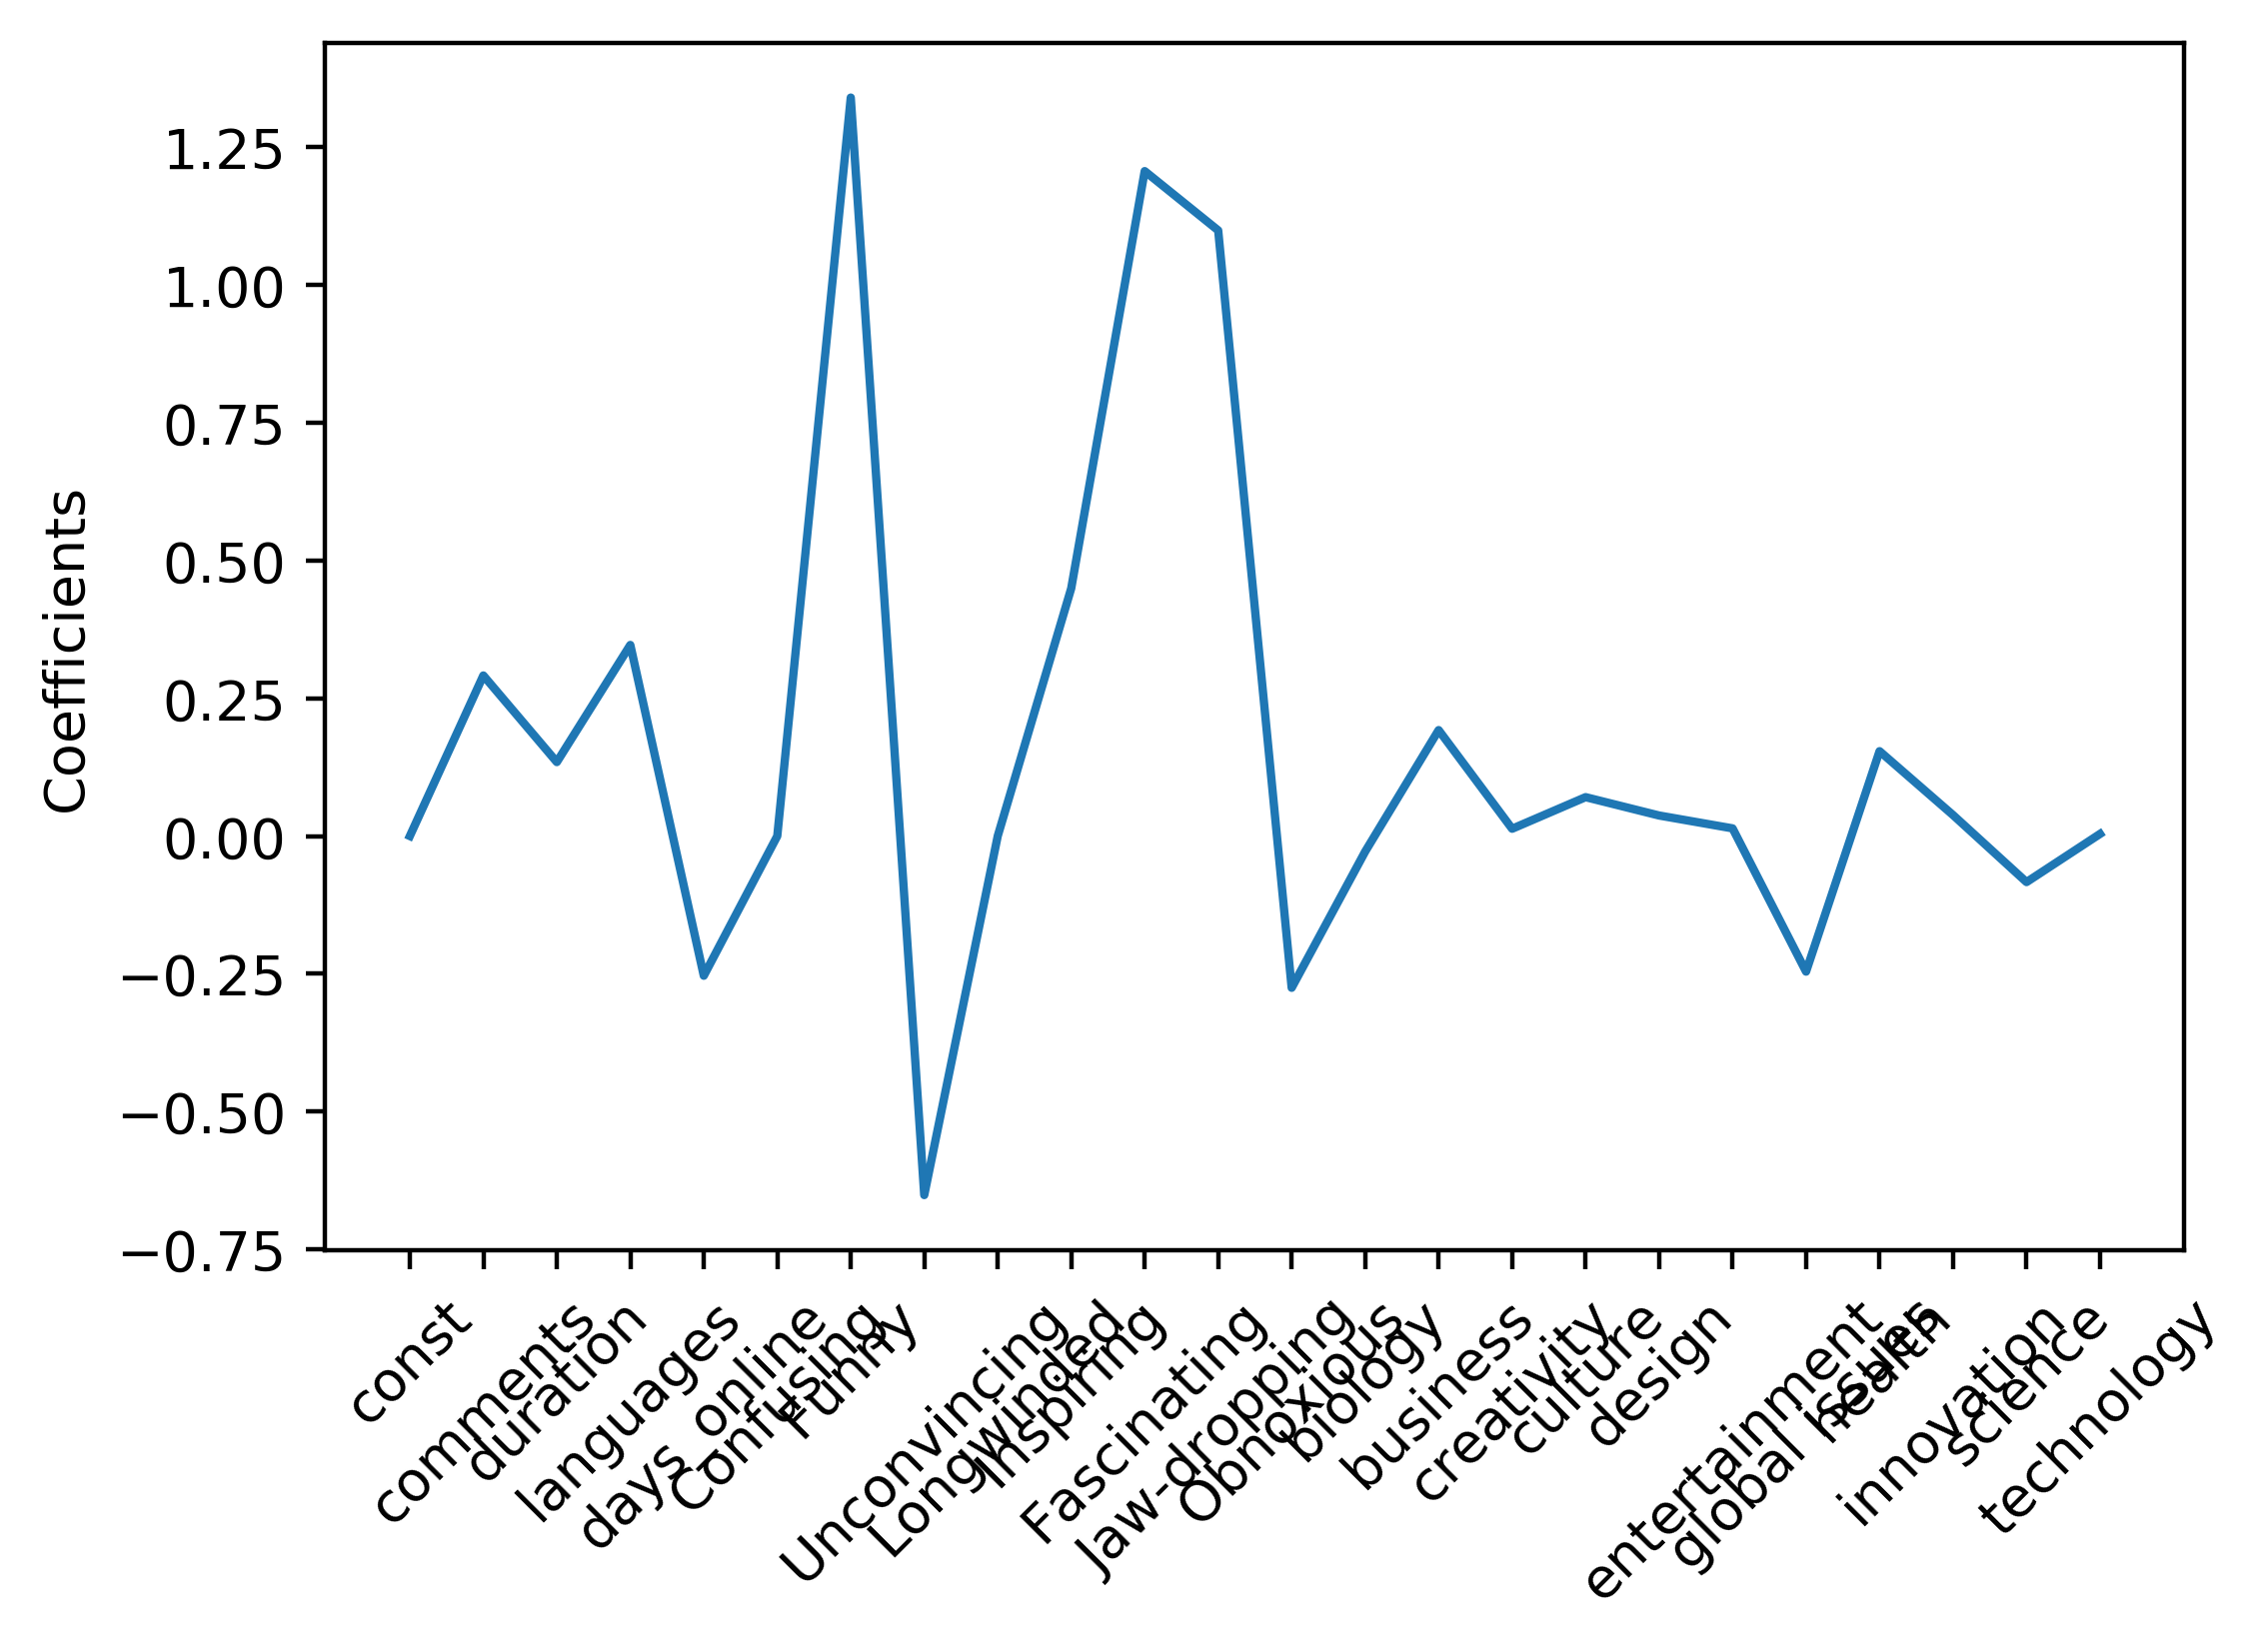

In [229]:
encv_coef = est.coef_
_ = plt.plot(range(len(X_train.columns)), encv_coef)
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=45)
_ = plt.ylabel('Coefficients')
plt.show()


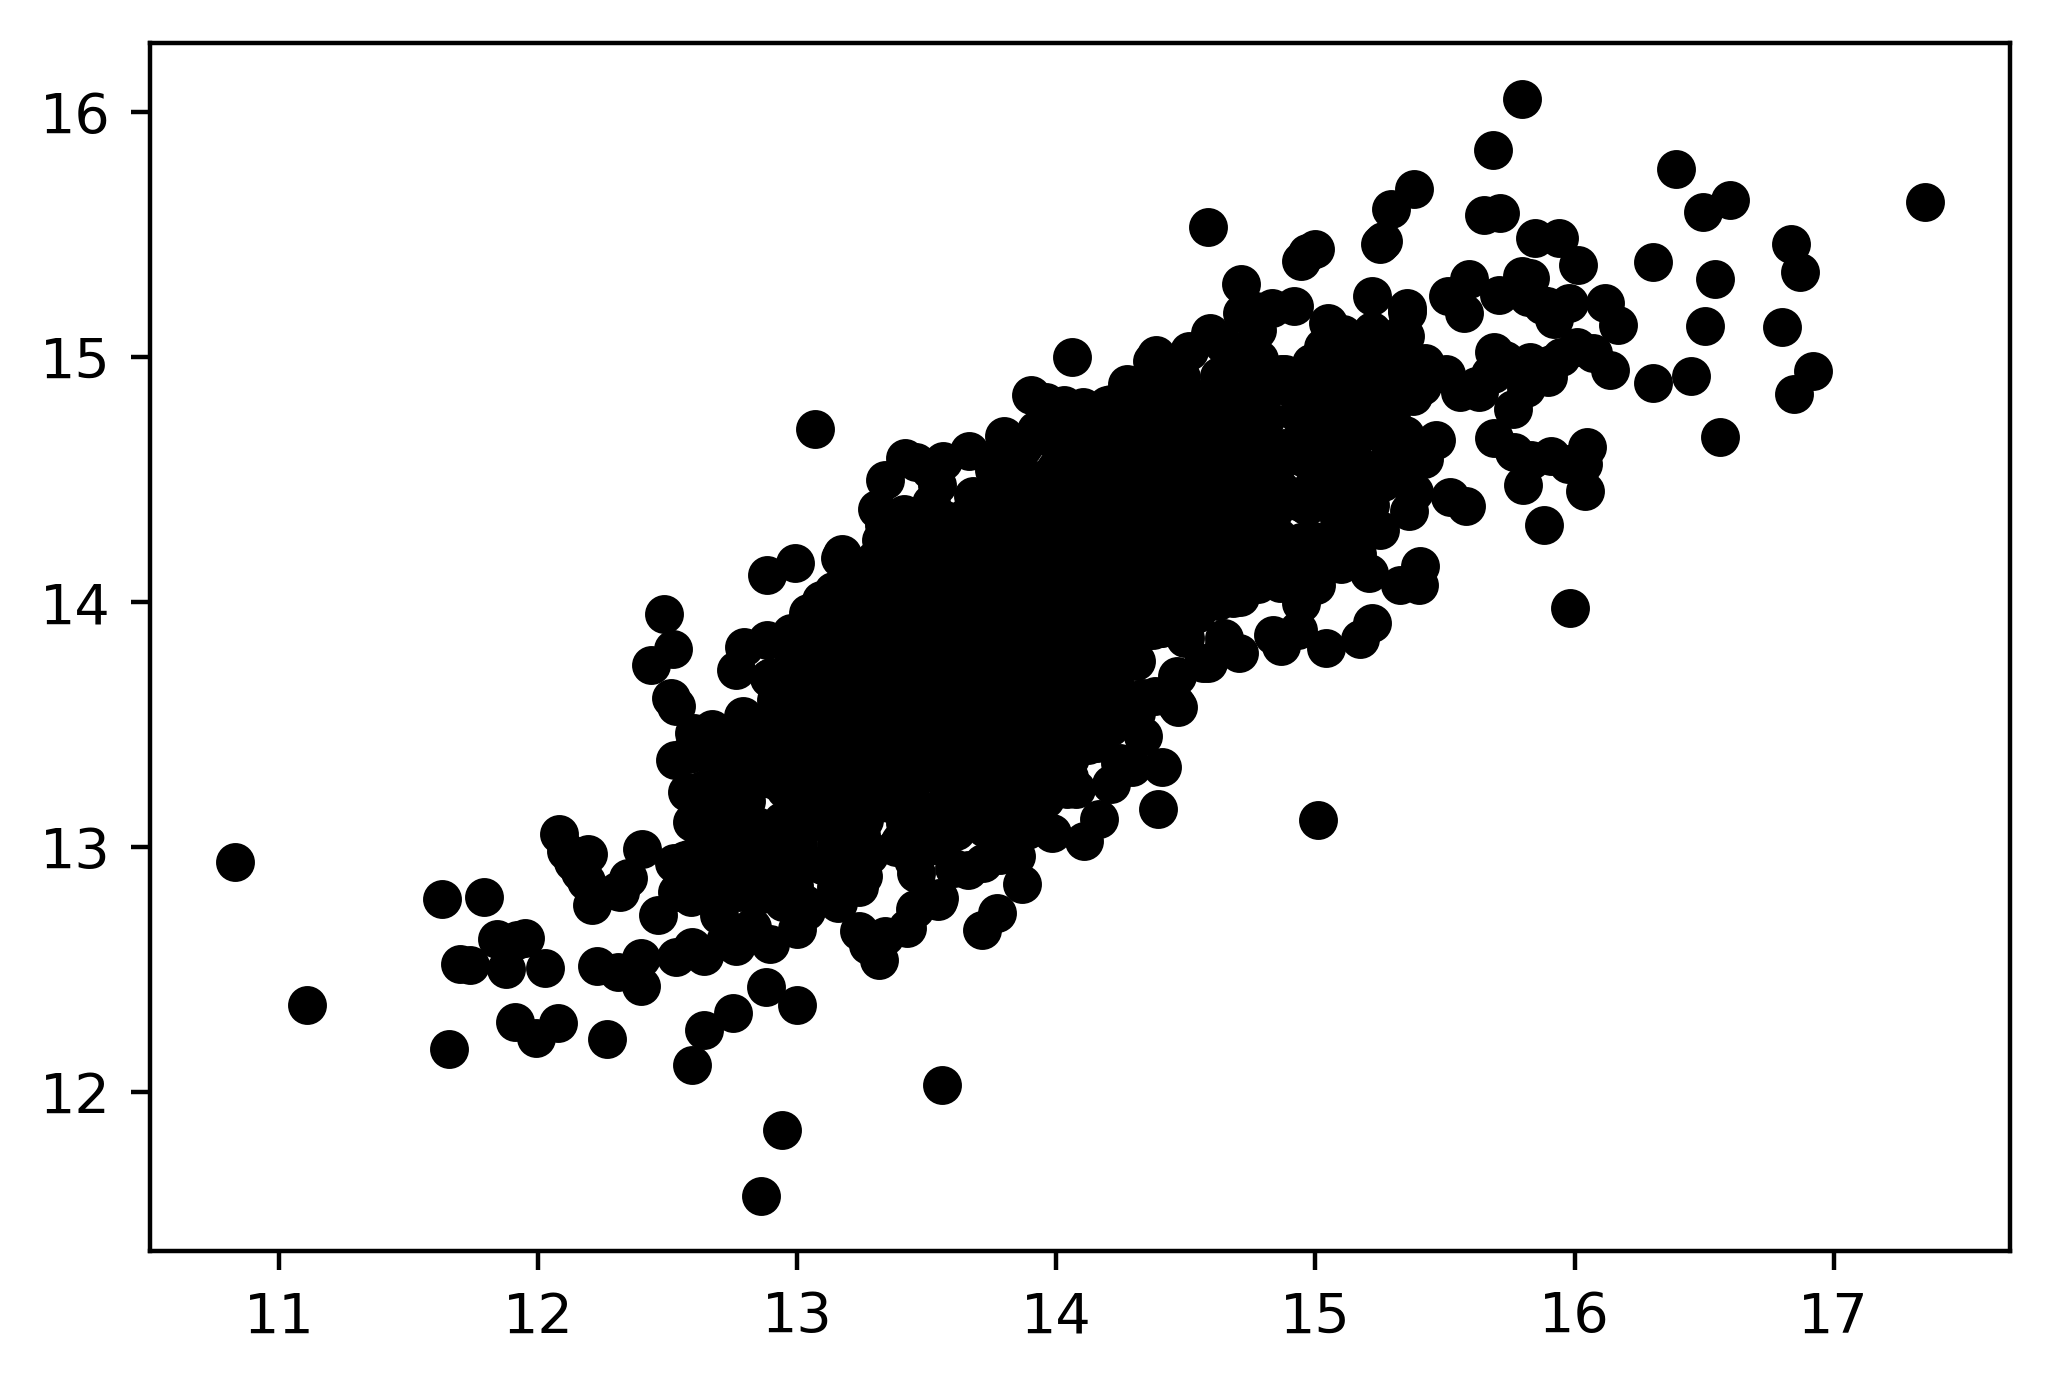

In [175]:
y_pred = est.predict(X_test)

# Plot outputs
#plt.scatter(X_test, y_test,  color='black')
plt.scatter(y_test, y_pred, color= 'black')

#plt.xticks(())
#plt.yticks(())

plt.show()

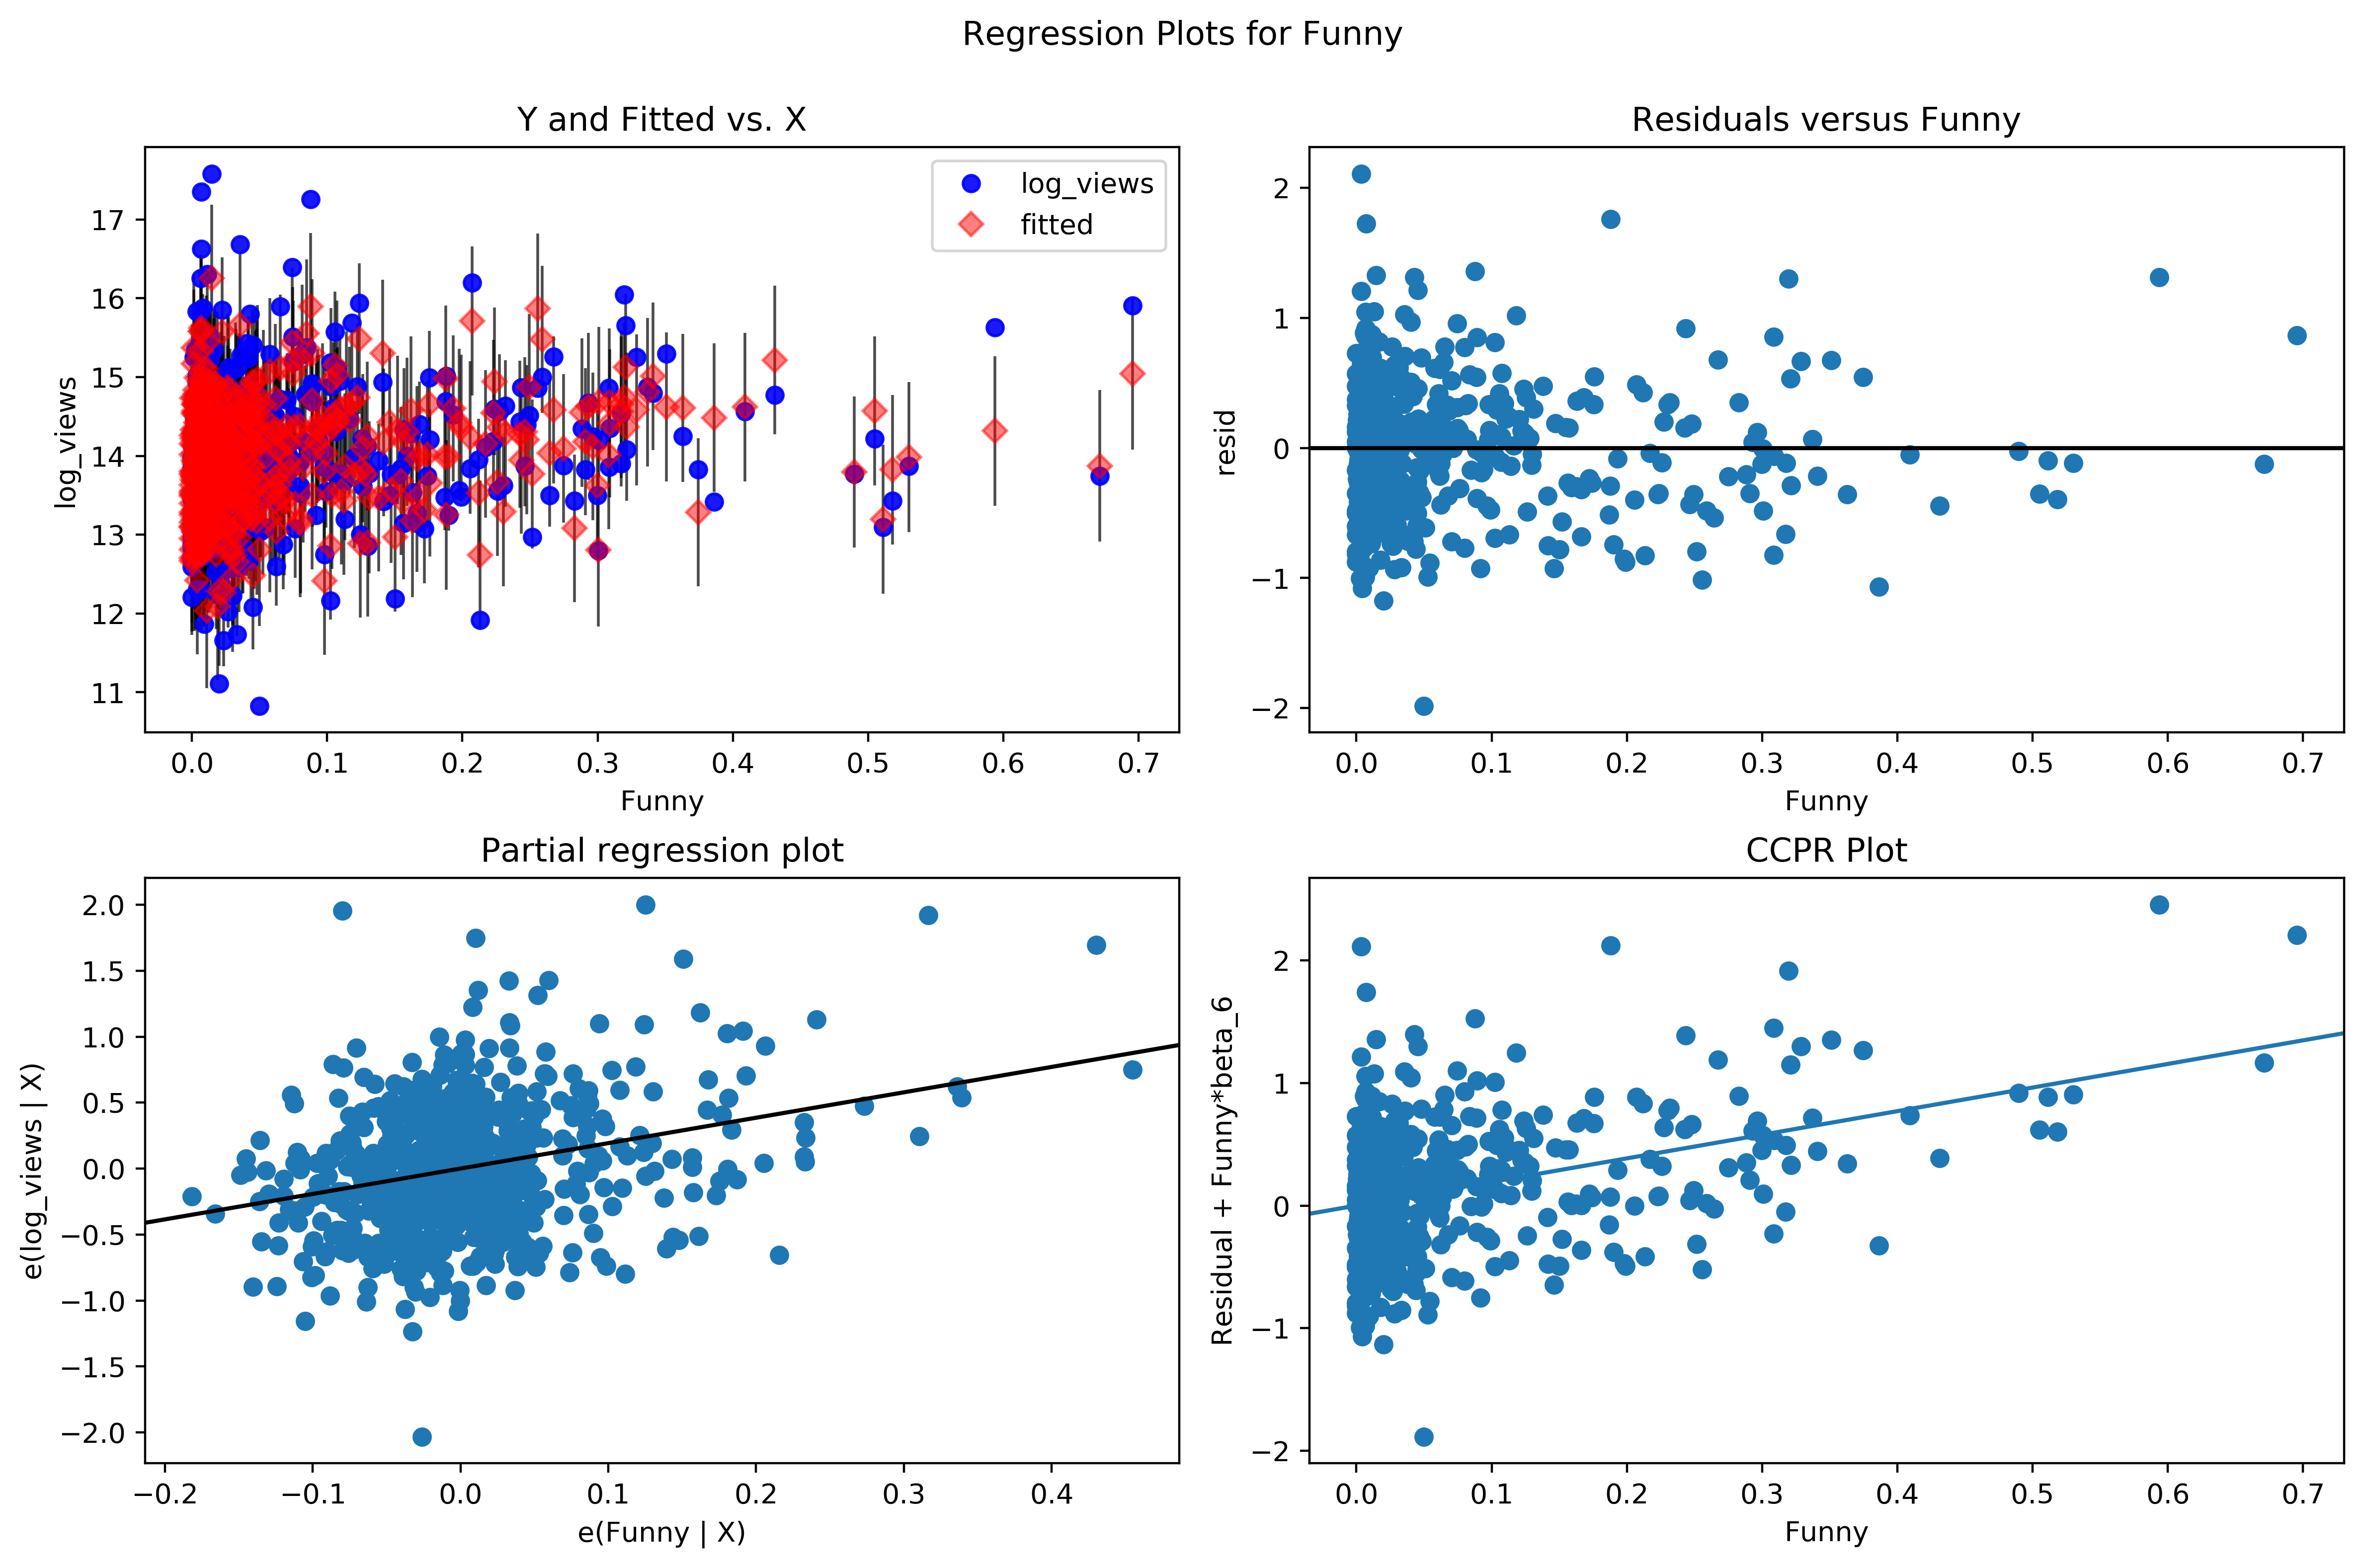

In [230]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fit1, "Funny", fig=fig)

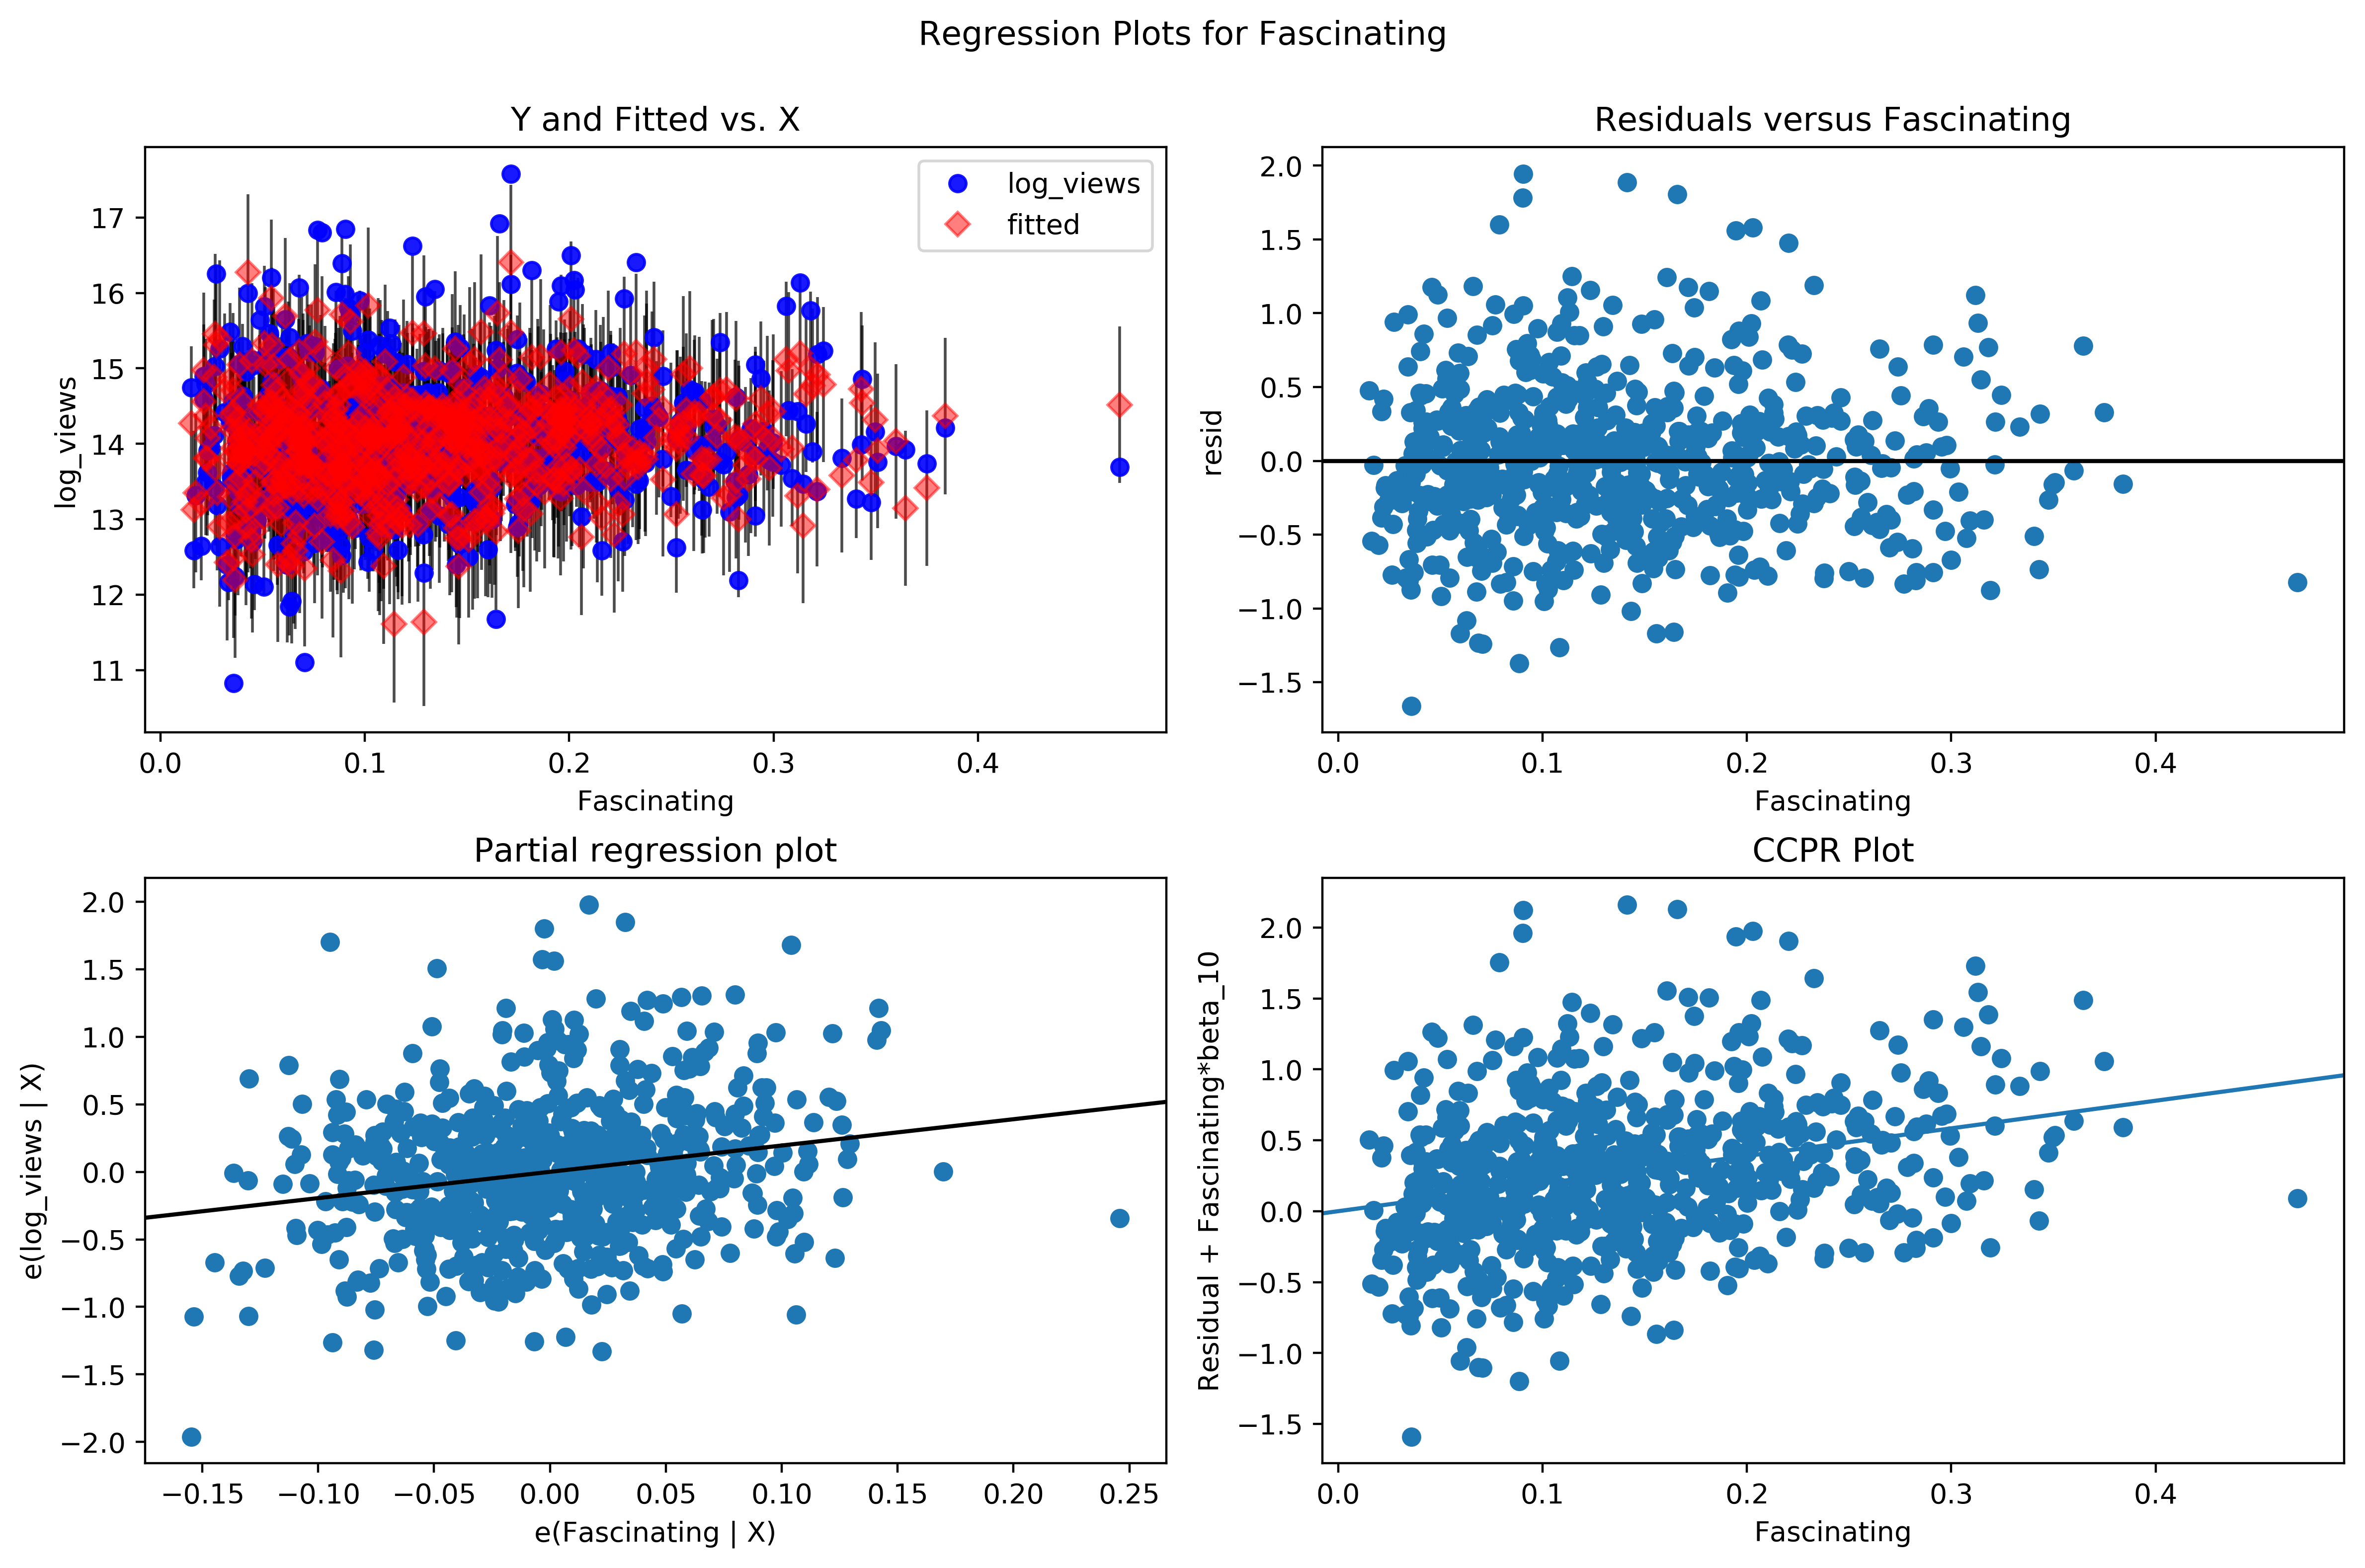

In [189]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fit1, "Fascinating", fig=fig)

## Transcripts of Presentations

Below is an analysis over the transcripts to see if any insight can be found.  Check to see how "Fascinating" and "Funny" ratings look compared to polarity or wpm.

In [481]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
transcripts = pd.read_csv('transcripts.csv')
colors = sns.diverging_palette(10, 220, sep=80, n=7)


In [491]:
transcripts['wc'] = transcripts['transcript'].apply(lambda x: len(x.split(' ')))
transcripts['wpm'] = (transcripts['wc']/data['duration']).replace(0,1)
transcripts['log_views'] = data['log_views']
test_trans = transcripts.copy()
transcripts = transcripts.dropna()

test_trans['wpm'] = test_trans['wc']/test_df['duration']


In [492]:
test_trans.dropna(inplace = True)

In [493]:
url_list = []
url_list = test_trans.url

In [494]:
#Writing a pickle file
import pickle

with open('url_list.pkl', 'wb') as picklefile:
    pickle.dump(url_list, picklefile)

In [495]:
ran = len(transcripts.transcript)

In [500]:
transcripts['positivity_index'] = ['' for i in range(len(transcripts['transcript']))]
transcripts['polarity_score'] = [0 for i in range(len(transcripts['transcript']))]
for i in range(0,ran):
    text = transcripts['transcript'][i]
    pos = TextBlob(text)
    pos_val = pos.sentiment.polarity
    transcripts.loc[i,'polarity_score'] = pos_val
    if pos_val > 0:
        transcripts.loc[i,'positivity_index'] = 'positive'
    else:
        transcripts.loc[i,'positivity_index'] = 'negative'
    


In [501]:
pos = TextBlob(text)
pos.sentiment.polarity

0.11102247275560158

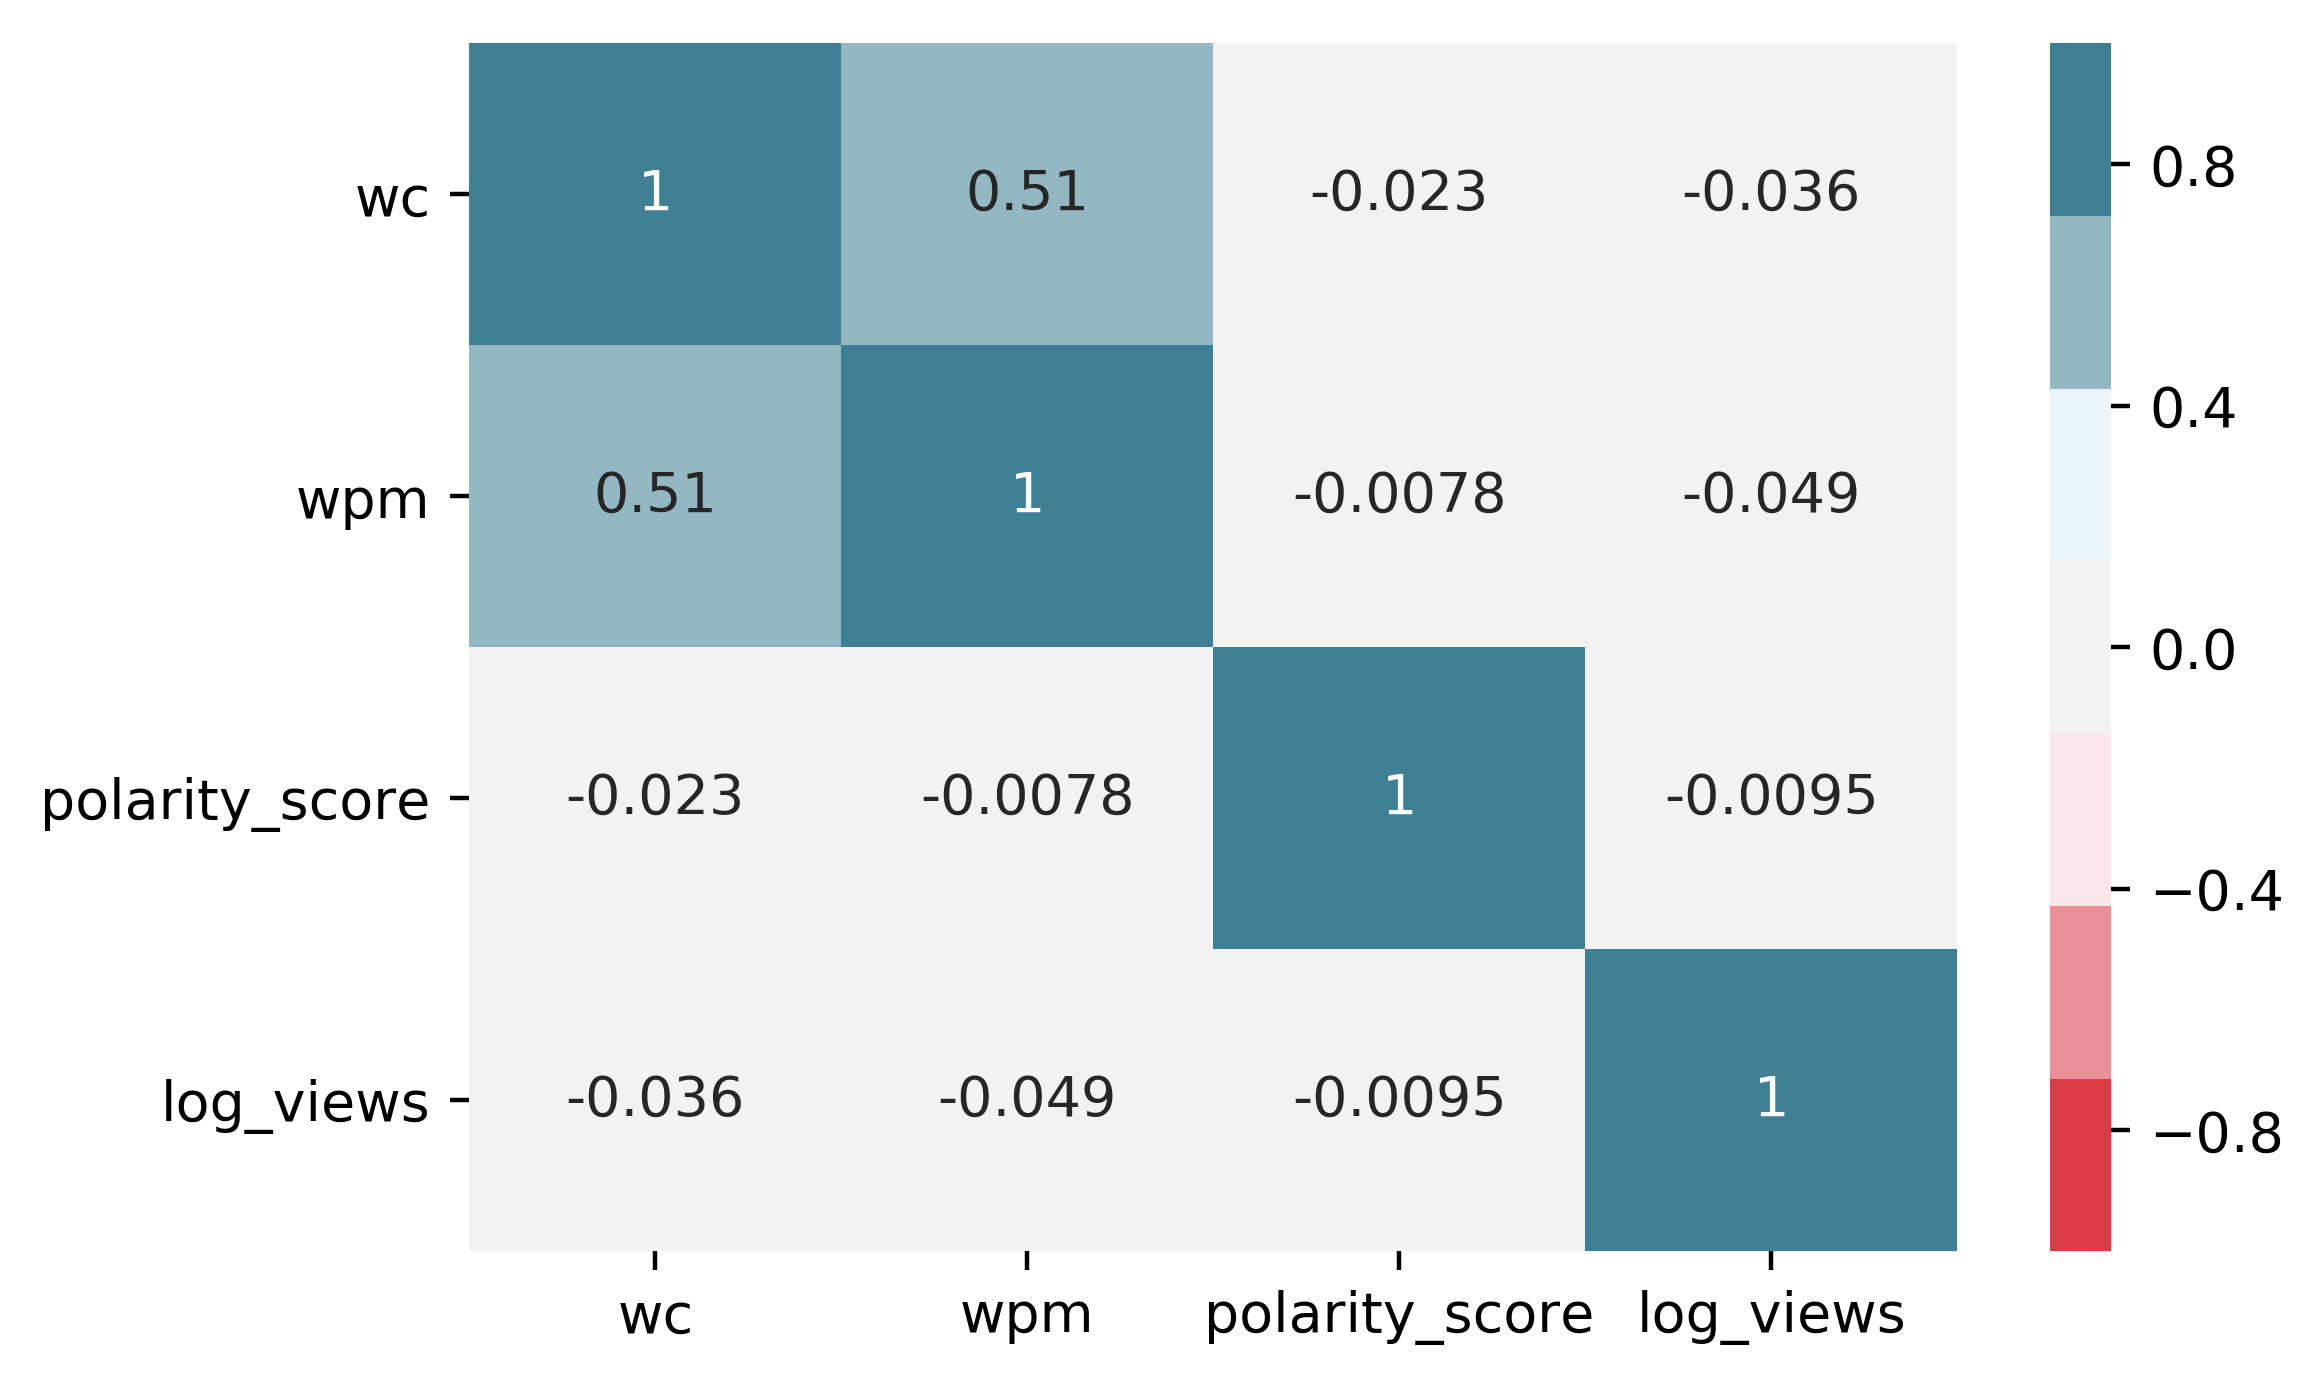

In [502]:
sns.heatmap(transcripts.corr(), vmin=-1, vmax=1,cmap=colors, annot = True)

In [474]:
trans_df = data.join(transcripts)
transcripts_df = tag_df.join(transcripts)


In [477]:
transcripts_df.head()

comments  duration  languages  days_online  log_views  Confusing  \
0  14.820346  0.883124   3.569507     2.066928  17.670479   0.002611   
1   0.197435  0.388393   1.638751     2.066928  14.978824   0.022686   
2  -0.283402  1.205017  -0.292005     2.066928  14.307943   0.010082   
3  -0.024228  0.756270   0.730160     2.066928  14.344697   0.008784   
4   1.315978  0.951308   2.206621     2.065909  16.300906   0.002838   

      Funny  Unconvincing  Longwinded  Inspiring       ...        health  \
0  0.211975      0.003237    0.004176   0.268937       ...             0   
1  0.199049      0.094402    0.041347   0.151116       ...             0   
2  0.359970      0.038835    0.029126   0.085885       ...             0   
3  0.016195      0.009882    0.014548   0.293714       ...             0   
4  0.054785      0.002641    0.004335   0.114023       ...             1   

   innovation  science  technology  \
0           0        0           0   
1           0        1           1   
2           0        0           1   
3           0        0           0   
4           0        0           0   

                                          transcript  \
0  Good morning. How are you?(Laughter)It's been ...   
1  Thank you so much, Chris. And it's truly a gre...   
2  (Music: "The Sound of Silence," Simon & Garfun...   
3  If you're here today — and I'm very happy that...   
4  About 10 years ago, I took on the task to teac...   

                                                 url    wc         wpm  \
0  https://www.ted.com/talks/ken_robinson_says_sc...  3066  158.041237   
1  https://www.ted.com/talks/al_gore_on_averting_...  2089  128.316953   
2  https://www.ted.com/talks/david_pogue_says_sim...  3253  151.796547   
3  https://www.ted.com/talks/majora_carter_s_tale...  3015  162.096774   
4  https://www.ted.com/talks/hans_rosling_shows_t...  3121  157.387796   

   positivity_index  polarity_score  
0          positive        0.146452  
1          positive        0.157775  
2          positive        0.136579  
3          positive       0.0829276  
4          positive       0.0964825  

[5 rows x 30 columns]

In [ ]:
(transcripts_df.loc[:,['Courageous', 'Beautiful', 'Confusing', 'Funny', 'Ingenious', 'Unconvincing', 'Longwinded', 'Informative', 'Inspiring', 'Fascinating', 'Persuasive', 'Jaw-dropping','Obnoxious',]].sum())/len(transcripts_df.positivity_index)*100

In [ ]:
['Courageous', 'Beautiful', 'Confusing', 'Funny', 'Ingenious', 'Unconvincing', 'Longwinded', 'Informative', 'Inspiring', 'Fascinating', 'Persuasive', 'Jaw-dropping']

In [ ]:
fig = sns.pairplot(transcripts_df, vars=['Courageous', 'Beautiful', 'Confusing', 'Funny', 'Ingenious', 'Unconvincing', 'Longwinded', 'Informative', 'Inspiring', 'Fascinating', 'Persuasive', 'Jaw-dropping','Obnoxious', 'log_views'], hue = 'positivity_index')


In [ ]:
fig = sns.lmplot(y="Informative", x="log_views", data=transcripts_df, hue = 'positivity_index',  fit_reg = False)


## Out of Sample Data

Below is reading and testing the model vs out of sample data.  This is how it would have been set up, however, the 

In [312]:
#reading a pickle file
with open("test_data.pkl", 'rb') as picklefun: 
    ofs_dict = pickle.load(picklefun)

In [313]:
ofs_df = pd.DataFrame.from_dict(ofs_dict, orient = 'index')
ofs_df.reset_index(drop = True, inplace=True)

In [314]:
ofs_df.columns = ['date_pub', 'views','tags']
ofs_df['days_online'] = ofs_df['date_pub'].apply(lambda x: ((dateutil.parser.parse('4/21/2018').date()-dateutil.parser.parse(x).date())))
ofs_df['days_online'] = (ofs_df['days_online']/np.timedelta64(1, 'D')).astype(int)
ofs_df['log_views'] = ofs_df['views'].apply(lambda x: math.log(x))

In [315]:
tag_dict2={}

In [316]:
ofs_tags={}
ofs_tags, unitags = allthetags(ofs_df.tags)
for i in range(len(ofs_df.tags)):
    tagg = ofs_df.tags[i]
    # for loop  to fill in 1s and 0s for the dummy variables
    for d in ofs_tags:
        if d in tagg:
            ofs_tags[d].append(1)
        else:
            ofs_tags[d].append(0) 


In [317]:
ofs_tag_df = pd.DataFrame.from_dict(ofs_tags, orient = 'columns')
ofs_tag_df.drop(0,0,inplace=True)
ofs_tag_df = ofs_tag_df.reset_index()

In [318]:
ofs_df = ofs_df.join(ofs_tag_df)


In [319]:
ofs_df.drop(['views', 'date_pub','tags'],1, inplace=True)

In [328]:
ofs_y = ofs_df.log_views
ofs_X = ofs_df.drop('log_views',1)

In [329]:
ofs_y.shape
ofs_X.shape

(179, 129)

In [330]:
elas.predict(ofs_X)

ValueError: shapes (179,129) and (377,) not aligned: 129 (dim 1) != 377 (dim 0)